In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Required libraries imported successfully.")

Required libraries imported successfully.


In [3]:

def clean_data(df):
    # Convert all column names to lowercase
    df.columns = df.columns.str.lower()
    # Create a new column with the mean of albedo_mod09ga and albedo_myd09ga
    # when both are available, or use the available value when only one is present.
    df['merged_albedo_mod09ga'] = df[['albedo_mod09ga', 'albedo_myd09ga']].mean(axis=1, skipna=True)
    # Move merged_albedo_mod09ga next to albedo columns of mod09ga
    albedo_columns = [col for col in df.columns if "albedo_mod09ga" in col]
    merged_index = df.columns.get_loc("merged_albedo_mod09ga")
    target_index = df.columns.get_loc(albedo_columns[-1]) + 1
    columns = list(df.columns)
    columns.insert(target_index, columns.pop(merged_index))
    df = df[columns]
    # Move 'merged_albedo_mod09ga' next to 'albedo_mod09ga'
    columns = df.columns.tolist()
    columns.remove('merged_albedo_mod09ga')
    mod09ga_index = columns.index('albedo_mod09ga') + 1
    columns.insert(mod09ga_index, 'merged_albedo_mod09ga')
    df = df[columns]
    # Create a new column 'merged_albedo_mod10a1' by merging 'albedo_mod10a1' and 'albedo_myd10a1'
    df['merged_albedo_mod10a1'] = df[['albedo_mod10a1', 'albedo_myd10a1']].mean(axis=1, skipna=True)
    # Move 'merged_albedo_mod10a1' next to 'albedo_mod10a1' in the DataFrame
    columns = list(df.columns)
    columns.remove('merged_albedo_mod10a1')
    mod10a1_index = columns.index('albedo_mod10a1')
    columns.insert(mod10a1_index + 1, 'merged_albedo_mod10a1')
    df = df[columns]
    
    # CORRECTED: Residual-based outlier detection (scientifically appropriate)
    # Calculate residuals between satellite and AWS measurements
    mod09ga_residuals = df['merged_albedo_mod09ga'] - df['albedo_aws']
    mod10a1_residuals = df['merged_albedo_mod10a1'] - df['albedo_aws']
    mcd43a3_residuals = df['albedo_mcd43a3'] - df['albedo_aws']
    
    # Calculate outlier thresholds based on residual statistics
    mod09ga_res_mean = np.nanmean(mod09ga_residuals)
    mod09ga_res_std = np.nanstd(mod09ga_residuals)
    mod10a1_res_mean = np.nanmean(mod10a1_residuals)
    mod10a1_res_std = np.nanstd(mod10a1_residuals)
    mcd43a3_res_mean = np.nanmean(mcd43a3_residuals)
    mcd43a3_res_std = np.nanstd(mcd43a3_residuals)
    
    # Flag outliers using 2.5σ threshold on residuals (recommended threshold)
    df['mod09ga_outlier'] = np.abs(mod09ga_residuals - mod09ga_res_mean) > 2.5 * mod09ga_res_std
    df['mod10a1_outlier'] = np.abs(mod10a1_residuals - mod10a1_res_mean) > 2.5 * mod10a1_res_std
    df['mcd43a3_outlier'] = np.abs(mcd43a3_residuals - mcd43a3_res_mean) > 2.5 * mcd43a3_res_std
    
    return df

def remove_outliers(df):
    """
    Create a dataset with outliers removed for clean analysis
    """
    # Remove rows where ANY product is flagged as an outlier
    clean_df = df[~(df['mod09ga_outlier'] | df['mod10a1_outlier'] | df['mcd43a3_outlier'])].copy()
    
    print(f"Original dataset: {len(df)} points")
    print(f"After removing outliers: {len(clean_df)} points")
    print(f"Outliers removed: {len(df) - len(clean_df)} points ({(len(df) - len(clean_df))/len(df)*100:.1f}%)")
    
    return clean_df

# Loaded variable 'df' from URI: d:\Documents\Projects\athabasca_analysis\data\csv\Athabasca_MultiProduct_with_AWS.csv
df = pd.read_csv(r'd:\Documents\Projects\athabasca_analysis\data\csv\Athabasca_MultiProduct_with_AWS.csv')

df_clean = clean_data(df.copy())

# Create versions with and without outliers
df_with_flags = df_clean.copy()  # Has outlier flags but keeps all data
df_no_outliers = remove_outliers(df_clean)  # Actually removes outlier rows

print("\nDataset options:")
print("- df_with_flags: All data with outlier flags (for showing outliers in plots)")
print("- df_no_outliers: Clean data with outliers removed (for clean statistics)")

df_clean.head()

Original dataset: 1298 points
After removing outliers: 1249 points
Outliers removed: 49 points (3.8%)

Dataset options:
- df_with_flags: All data with outlier flags (for showing outliers in plots)
- df_no_outliers: Clean data with outliers removed (for clean statistics)


,pixel_id,date,qa_mode,albedo_mod09ga,merged_albedo_mod09ga,albedo_myd09ga,albedo_mcd43a3,albedo_mod10a1,merged_albedo_mod10a1,albedo_myd10a1,...,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,mod09ga_outlier,mod10a1_outlier,mcd43a3_outlier
0,9073025950,2014-06-01,qa_0_and_1,NaN,NaN,NaN,0.482,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,9073025950,2014-06-01,renoriginal,0.334372,0.334372,NaN,NaN,NaN,NaN,NaN,...,0.3995,0.3269,0.4097,0.4115,0.0993,0.0517,0.0414,False,False,False
2,9073025950,2014-06-01,standard_qa,NaN,NaN,NaN,NaN,0.29,0.29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,9073025950,2014-06-02,qa_0_and_1,NaN,NaN,NaN,0.486,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
4,9073025950,2014-06-03,qa_0_and_1,NaN,NaN,NaN,0.491,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


In [4]:
print(df.columns.tolist())

['pixel_id', 'date', 'qa_mode', 'albedo_MOD09GA', 'albedo_MYD09GA', 'albedo_mcd43a3', 'albedo_mod10a1', 'albedo_myd10a1', 'albedo_AWS', 'ndsi_MOD09GA', 'ndsi_MYD09GA', 'ndsi_mcd43a3', 'ndsi_mod10a1', 'ndsi_myd10a1', 'glacier_fraction_MOD09GA', 'glacier_fraction_MYD09GA', 'glacier_fraction_mcd43a3', 'glacier_fraction_mod10a1', 'glacier_fraction_myd10a1', 'solar_zenith_MOD09GA', 'solar_zenith_MYD09GA', 'solar_zenith_mcd43a3', 'solar_zenith_mod10a1', 'solar_zenith_myd10a1', 'elevation', 'slope', 'aspect', 'longitude', 'latitude', 'tile_h', 'tile_v', 'pixel_row', 'pixel_col', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']


In [ ]:
# Display first rows of the clean DataFrame (outliers removed)
df_no_outliers.head()

,pixel_id,date,qa_mode,albedo_mod09ga,merged_albedo_mod09ga,albedo_myd09ga,albedo_mcd43a3,albedo_mod10a1,merged_albedo_mod10a1,albedo_myd10a1,...,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,mod09ga_outlier,mod10a1_outlier,mcd43a3_outlier
0,9073025950,2014-06-01,qa_0_and_1,NaN,NaN,NaN,0.482,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,9073025950,2014-06-01,renoriginal,0.334372,0.334372,NaN,NaN,NaN,NaN,NaN,...,0.3995,0.3269,0.4097,0.4115,0.0993,0.0517,0.0414,False,False,False
2,9073025950,2014-06-01,standard_qa,NaN,NaN,NaN,NaN,0.29,0.29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,9073025950,2014-06-02,qa_0_and_1,NaN,NaN,NaN,0.486,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
4,9073025950,2014-06-03,qa_0_and_1,NaN,NaN,NaN,0.491,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,9075025945,2020-09-27,standard_qa,NaN,NaN,NaN,NaN,0.47,0.55,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1294,9075025945,2020-09-28,qa_0_and_1,NaN,NaN,NaN,0.149,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1295,9075025945,2020-09-29,qa_0_and_1,NaN,NaN,NaN,0.149,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1296,9075025945,2020-09-30,renoriginal,0.232485,0.206787,0.181088,NaN,NaN,NaN,NaN,...,0.2363,0.1431,0.2782,0.2748,0.0357,0.0156,0.0097,False,False,False


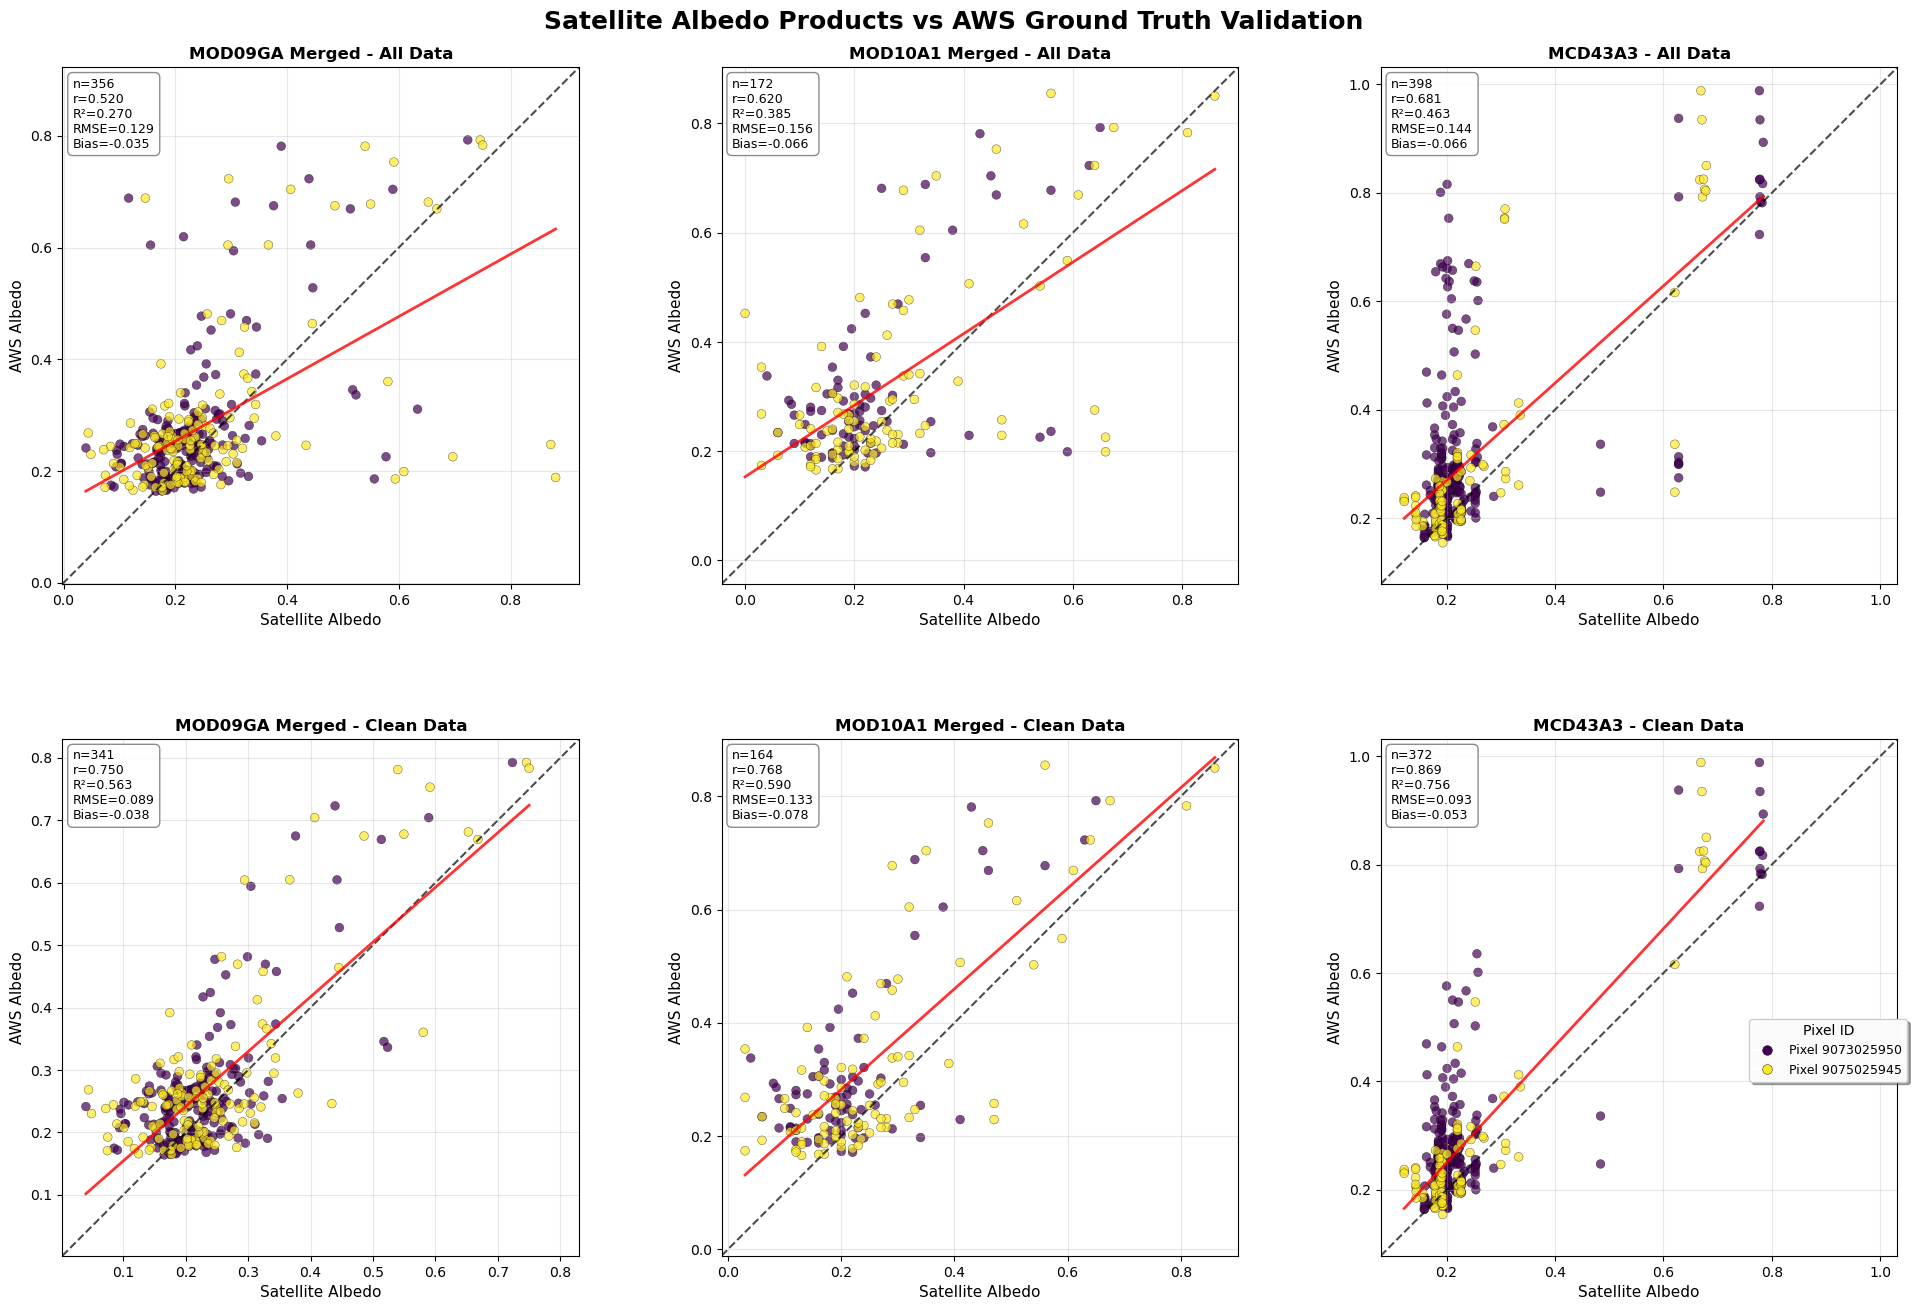


=== VALIDATION STATISTICS (outliers removed) ===
Product       | n    | r     | R²    | Bias  | RMSE  | MAE   
-----------------------------------------------------------------
MOD09GA Merged |  341 | 0.750 | 0.563 | -0.038 | 0.089 | 0.066
MOD10A1 Merged |  164 | 0.768 | 0.590 | -0.078 | 0.133 | 0.102
MCD43A3      |  372 | 0.869 | 0.756 | -0.053 | 0.093 | 0.062

Dataset: 1249/1298 points (3.8% outliers removed)


In [10]:
# Satellite Albedo vs AWS Validation Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuration
plt.style.use('default')
sns.set_palette("husl")

PRODUCTS = [
    {'name': 'merged_albedo_mod09ga', 'title': 'MOD09GA Merged', 'color': 'skyblue', 'edge': 'navy'},
    {'name': 'merged_albedo_mod10a1', 'title': 'MOD10A1 Merged', 'color': 'forestgreen', 'edge': 'darkgreen'},
    {'name': 'albedo_mcd43a3', 'title': 'MCD43A3', 'color': 'orange', 'edge': 'darkorange'}
]

# Global color mapping for pixel_id consistency
unique_pixel_ids = np.unique(df_with_flags['pixel_id'])
cmap = plt.get_cmap('viridis', len(unique_pixel_ids))
pixel_colors = {pid: cmap(i) for i, pid in enumerate(unique_pixel_ids)}

# Helper Functions
def calculate_stats(y_true, y_pred):
    """Calculate validation statistics"""
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    if not np.any(mask):
        return {'bias': np.nan, 'r': np.nan, 'rmse': np.nan, 'mae': np.nan, 'n': 0}
    
    y_clean, pred_clean = y_true[mask], y_pred[mask]
    return {
        'bias': np.mean(pred_clean - y_clean),
        'r': np.corrcoef(y_clean, pred_clean)[0, 1],
        'rmse': np.sqrt(mean_squared_error(y_clean, pred_clean)),
        'mae': mean_absolute_error(y_clean, pred_clean),
        'n': len(y_clean)
    }

def plot_scatter(ax, x, y, title, stats, color='blue', edge='darkblue'):
    """Create scatter plot with regression and statistics"""
    # Clean data
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]
    
    # Scatter plot with pixel coloring
    pixel_ids = df_with_flags['pixel_id'].values[mask] if len(x) == len(df_with_flags) else df_no_outliers['pixel_id'].values[mask]
    colors = [pixel_colors[pid] for pid in pixel_ids]
    ax.scatter(x_clean, y_clean, c=colors, alpha=0.7, s=40, edgecolors='black', linewidth=0.3)
    
    # Set consistent square limits for all plots
    min_val = min(np.min(x_clean), np.min(y_clean))
    max_val = max(np.max(x_clean), np.max(y_clean))
    # Add padding for better visualization
    padding = (max_val - min_val) * 0.05
    lims = [min_val - padding, max_val + padding]
    
    # Reference line (1:1)
    ax.plot(lims, lims, 'k--', alpha=0.7, linewidth=1.5)  # 1:1 line
    
    # Regression line only across data range
    if len(x_clean) > 1:
        coeffs = np.polyfit(x_clean, y_clean, 1)
        x_data_range = [np.min(x_clean), np.max(x_clean)]
        y_reg_range = coeffs[0] * np.array(x_data_range) + coeffs[1]
        ax.plot(x_data_range, y_reg_range, 'r-', linewidth=2, alpha=0.8)
    
    # Statistics box
    r2 = stats['r']**2 if not np.isnan(stats['r']) else np.nan
    stats_text = f"n={stats['n']}\nr={stats['r']:.3f}\nR²={r2:.3f}\nRMSE={stats['rmse']:.3f}\nBias={stats['bias']:.3f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # Formatting with consistent square limits
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel('Satellite Albedo', fontsize=11)
    ax.set_ylabel('AWS Albedo', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

# Main Plotting
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Satellite Albedo Products vs AWS Ground Truth Validation', fontsize=18, fontweight='bold', y=0.95)

# Create plots for each product
for i, product in enumerate(PRODUCTS):
    # All data (top row)
    stats_all = calculate_stats(df_with_flags['albedo_aws'].values, df_with_flags[product['name']].values)
    plot_scatter(axes[0, i], df_with_flags[product['name']].values, df_with_flags['albedo_aws'].values,
                f"{product['title']} - All Data", stats_all, product['color'], product['edge'])
    
    # Clean data (bottom row)
    stats_clean = calculate_stats(df_no_outliers['albedo_aws'].values, df_no_outliers[product['name']].values)
    plot_scatter(axes[1, i], df_no_outliers[product['name']].values, df_no_outliers['albedo_aws'].values,
                f"{product['title']} - Clean Data", stats_clean, product['color'], product['edge'])

# Legend for pixel IDs
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=pixel_colors[pid], 
                           markersize=7, markeredgecolor='black', markeredgewidth=0.3, label=f'Pixel {pid}') 
                 for pid in sorted(pixel_colors.keys())]
fig.legend(handles=legend_handles, title='Pixel ID', loc='lower right', fontsize=9, title_fontsize=10,
           frameon=True, fancybox=True, shadow=True, framealpha=0.97, bbox_to_anchor=(0.98, 0.18))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

# Summary Statistics Table
print("\n=== VALIDATION STATISTICS (outliers removed) ===")
print("Product       | n    | r     | R²    | Bias  | RMSE  | MAE   ")
print("-" * 65)
for product in PRODUCTS:
    stats = calculate_stats(df_no_outliers['albedo_aws'].values, df_no_outliers[product['name']].values)
    r2 = stats['r']**2 if not np.isnan(stats['r']) else np.nan
    print(f"{product['title']:12} | {stats['n']:4d} | {stats['r']:5.3f} | {r2:5.3f} | {stats['bias']:5.3f} | {stats['rmse']:5.3f} | {stats['mae']:5.3f}")

print(f"\nDataset: {len(df_no_outliers)}/{len(df_with_flags)} points ({(len(df_with_flags)-len(df_no_outliers))/len(df_with_flags)*100:.1f}% outliers removed)")

=== MOD09GA ENVIRONMENTAL ANALYSIS ===

NDSI Analysis:
  Data points: 285
  NDSI range: -0.144 to 0.933
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=0.050 (p=0.404)
  Correlation with |residuals|: r=-0.121 (p=0.042)

Solar Zenith Analysis:
  Data points: 285
  Solar Zenith range: 28.800 to 56.150
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=-0.317 (p=0.000)
  Correlation with |residuals|: r=0.405 (p=0.000)

Glacier Fraction Analysis:
  Data points: 285
  Glacier Fraction range: 0.659 to 0.969
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=0.042 (p=0.478)
  Correlation with |residuals|: r=-0.120 (p=0.042)


=== MOD09GA ENVIRONMENTAL ANALYSIS ===

NDSI Analysis:
  Data points: 285
  NDSI range: -0.144 to 0.933
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=0.050 (p=0.404)
  Correlation with |residuals|: r=-0.121 (p=0.042)

Solar Zenith Analysis:
  Data points: 285
  Solar Zenith range: 28.800 to 56.150
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=-0.317 (p=0.000)
  Correlation with |residuals|: r=0.405 (p=0.000)

Glacier Fraction Analysis:
  Data points: 285
  Glacier Fraction range: 0.659 to 0.969
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=0.042 (p=0.478)
  Correlation with |residuals|: r=-0.120 (p=0.042)


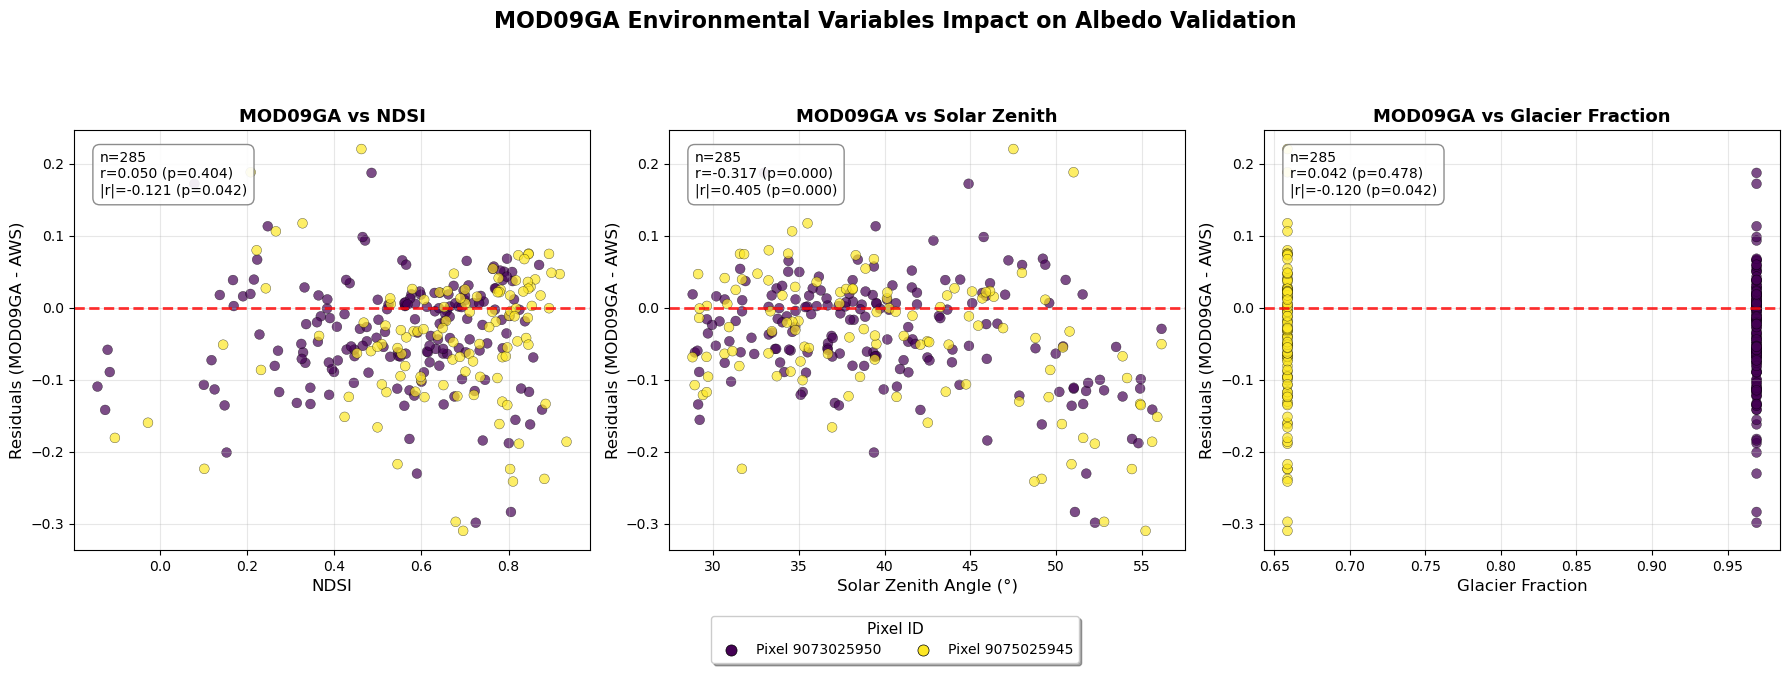


Analysis based on 1249 clean data points


In [13]:
# MOD09GA Environmental Impact Analysis: NDSI, Solar Zenith, and Glacier Fraction
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def analyze_environmental_impact(df, env_var, product_col, reference_col='albedo_aws'):
    """Analyze how environmental variables affect validation performance"""
    # Check if columns exist and remove NaN values
    mask = ~(np.isnan(df[env_var]) | np.isnan(df[product_col]) | np.isnan(df[reference_col]))
    data = df[mask].copy()
    
    if len(data) < 5:
        return None
    
    # Calculate residuals
    data['residuals'] = data[product_col] - data[reference_col]
    data['abs_residuals'] = np.abs(data['residuals'])
    
    return data

# MOD09GA Environmental Analysis
product_col = 'merged_albedo_mod09ga'
env_variables = [
    ('ndsi_mod09ga', 'NDSI', 'NDSI'),
    ('solar_zenith_mod09ga', 'Solar Zenith Angle (°)', 'Solar Zenith'),  
    ('glacier_fraction_mod09ga', 'Glacier Fraction', 'Glacier Fraction')
]

# Create 1x3 subplot for MOD09GA only
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('MOD09GA Environmental Variables Impact on Albedo Validation', fontsize=16, fontweight='bold')

print("=== MOD09GA ENVIRONMENTAL ANALYSIS ===")

for i, (env_var, xlabel, title) in enumerate(env_variables):
    if env_var in df_no_outliers.columns:
        data = analyze_environmental_impact(df_no_outliers, env_var, product_col)
        
        if data is not None and len(data) > 0:
            print(f"\n{title} Analysis:")
            print(f"  Data points: {len(data)}")
            print(f"  {title} range: {data[env_var].min():.3f} to {data[env_var].max():.3f}")
            print(f"  Residual range: {data['residuals'].min():.3f} to {data['residuals'].max():.3f}")
            
            # Scatter plot with pixel coloring
            colors = [pixel_colors[pid] for pid in data['pixel_id']]
            axes[i].scatter(data[env_var], data['residuals'], c=colors, alpha=0.7, s=50, 
                           edgecolors='black', linewidth=0.3)
            
            # Zero line
            axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
            
            # Formatting
            axes[i].set_xlabel(xlabel, fontsize=12)
            axes[i].set_ylabel('Residuals (MOD09GA - AWS)', fontsize=12)
            axes[i].set_title(f'MOD09GA vs {title}', fontsize=13, fontweight='bold')
            axes[i].grid(True, alpha=0.3)
            
            # Add correlation statistics
            try:
                r, p = stats.pearsonr(data[env_var], data['residuals'])
                r_abs, p_abs = stats.pearsonr(data[env_var], data['abs_residuals'])
                
                stats_text = f'n={len(data)}\nr={r:.3f} (p={p:.3f})\n|r|={r_abs:.3f} (p={p_abs:.3f})'
                axes[i].text(0.05, 0.95, stats_text, transform=axes[i].transAxes, 
                           fontsize=10, va='top', ha='left',
                           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))
                
                print(f"  Correlation with residuals: r={r:.3f} (p={p:.3f})")
                print(f"  Correlation with |residuals|: r={r_abs:.3f} (p={p_abs:.3f})")
                
            except Exception as e:
                print(f"  Could not calculate correlations: {e}")
        else:
            axes[i].text(0.5, 0.5, f'Insufficient data\nfor {title} analysis', 
                        transform=axes[i].transAxes, ha='center', va='center', fontsize=12)
            axes[i].set_title(f'MOD09GA vs {title}', fontsize=13)
            print(f"\n{title}: Insufficient data for analysis")
    else:
        axes[i].text(0.5, 0.5, f'{title} column\nnot found', 
                    transform=axes[i].transAxes, ha='center', va='center', fontsize=12)
        axes[i].set_title(f'MOD09GA vs {title}', fontsize=13)
        print(f"\n{title}: Column '{env_var}' not found")

# Add pixel legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=pixel_colors[pid], 
                           markersize=8, markeredgecolor='black', markeredgewidth=0.5, label=f'Pixel {pid}') 
                 for pid in sorted(pixel_colors.keys())]
fig.legend(handles=legend_handles, title='Pixel ID', loc='lower center', ncol=len(pixel_colors), 
           fontsize=10, title_fontsize=11, frameon=True, fancybox=True, shadow=True, 
           bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

print(f"\nAnalysis based on {len(df_no_outliers)} clean data points")

=== SOLAR ZENITH ANGLE vs DATE ANALYSIS ===
Data points: 398
Date range: 2014-06-01 to 2020-09-30
Day of year range: 152 to 274
Solar zenith range: 28.770° to 56.150°
Correlation (day of year vs solar zenith): r=0.952 (p=0.000)
R² = 0.906 (90.6% of variance explained)

Monthly Solar Zenith Statistics:
         mean    std  count
month                      
6      30.346  1.409     50
7      33.638  2.470    111
8      40.032  2.965    128
9      50.651  3.435    109


C:\Users\thier\AppData\Local\Temp\ipykernel_26072\887260110.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(monthly_data, labels=[month_labels[m-1] for m in months])


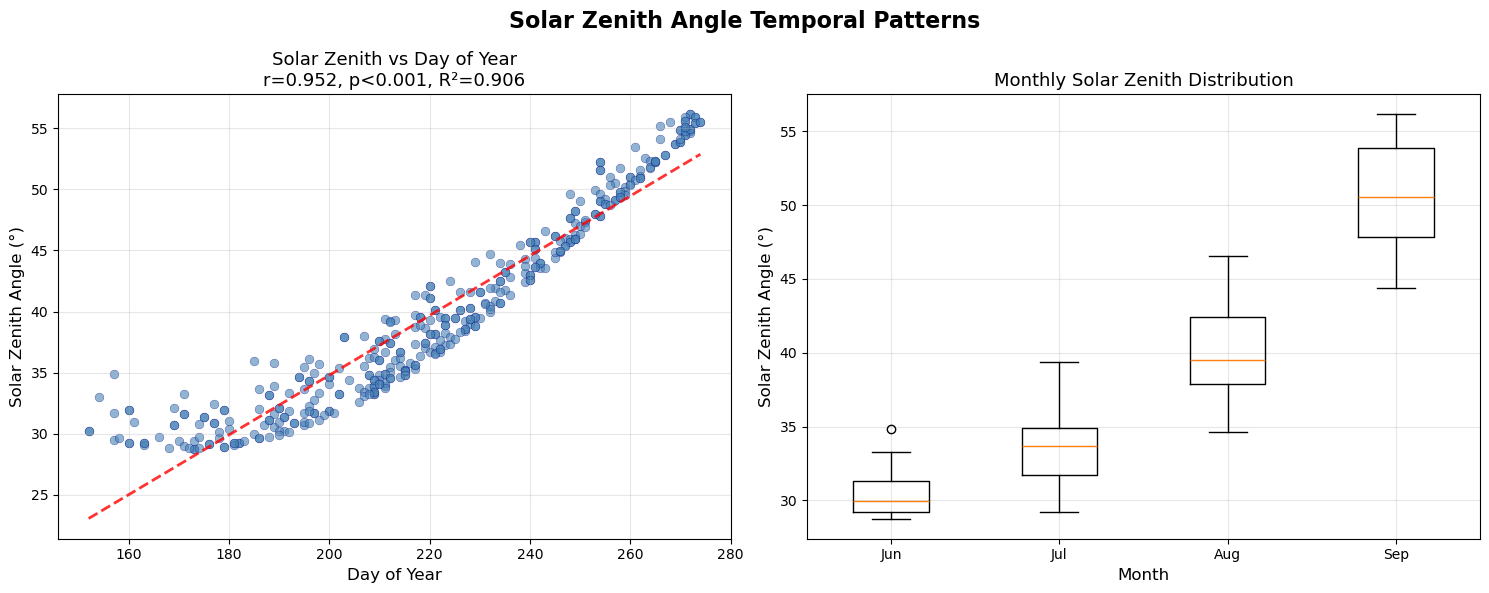


=== INTERPRETATION ===
• Very strong correlation (r=0.952) between day of year and solar zenith angle
• 90.6% of solar zenith variation explained by seasonal position
• Data spans June-September (day 152-274)
• Solar zenith increases 0.245°/day through summer-autumn transition


In [5]:
# Solar Zenith Angle vs Date Analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Convert date column to datetime and extract day of year
df_no_outliers_copy = df_no_outliers.copy()
df_no_outliers_copy['date'] = pd.to_datetime(df_no_outliers_copy['date'])
df_no_outliers_copy['day_of_year'] = df_no_outliers_copy['date'].dt.dayofyear

# Remove NaN values for solar zenith analysis
mask = ~np.isnan(df_no_outliers_copy['solar_zenith_mod09ga'])
data_clean = df_no_outliers_copy[mask].copy()

print("=== SOLAR ZENITH ANGLE vs DATE ANALYSIS ===")
print(f"Data points: {len(data_clean)}")
print(f"Date range: {data_clean['date'].min().strftime('%Y-%m-%d')} to {data_clean['date'].max().strftime('%Y-%m-%d')}")
print(f"Day of year range: {data_clean['day_of_year'].min()} to {data_clean['day_of_year'].max()}")
print(f"Solar zenith range: {data_clean['solar_zenith_mod09ga'].min():.3f}° to {data_clean['solar_zenith_mod09ga'].max():.3f}°")

# Calculate correlation
r_doy, p_doy = stats.pearsonr(data_clean['day_of_year'], data_clean['solar_zenith_mod09ga'])
print(f"Correlation (day of year vs solar zenith): r={r_doy:.3f} (p={p_doy:.3f})")
print(f"R² = {r_doy**2:.3f} ({r_doy**2*100:.1f}% of variance explained)")

# Monthly aggregation
data_clean['month'] = data_clean['date'].dt.month
monthly_stats = data_clean.groupby('month')['solar_zenith_mod09ga'].agg(['mean', 'std', 'count']).round(3)
print(f"\nMonthly Solar Zenith Statistics:")
print(monthly_stats)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Solar Zenith Angle Temporal Patterns', fontsize=16, fontweight='bold')

# Plot 1: Solar zenith vs day of year
ax1.scatter(data_clean['day_of_year'], data_clean['solar_zenith_mod09ga'], 
           alpha=0.6, s=40, c='steelblue', edgecolors='navy', linewidth=0.3)

# Add trend line
z = np.polyfit(data_clean['day_of_year'], data_clean['solar_zenith_mod09ga'], 1)
p = np.poly1d(z)
ax1.plot(data_clean['day_of_year'], p(data_clean['day_of_year']), "r--", alpha=0.8, linewidth=2)

ax1.set_xlabel('Day of Year', fontsize=12)
ax1.set_ylabel('Solar Zenith Angle (°)', fontsize=12)
ax1.set_title(f'Solar Zenith vs Day of Year\nr={r_doy:.3f}, p<0.001, R²={r_doy**2:.3f}', fontsize=13)
ax1.grid(True, alpha=0.3)

# Plot 2: Monthly boxplot
monthly_data = [data_clean[data_clean['month'] == m]['solar_zenith_mod09ga'].values 
                for m in sorted(data_clean['month'].unique())]
months = sorted(data_clean['month'].unique())
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax2.boxplot(monthly_data, labels=[month_labels[m-1] for m in months])
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Solar Zenith Angle (°)', fontsize=12)
ax2.set_title('Monthly Solar Zenith Distribution', fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check seasonal patterns
winter_months = [12, 1, 2]
summer_months = [6, 7, 8]

winter_data = data_clean[data_clean['month'].isin(winter_months)]
summer_data = data_clean[data_clean['month'].isin(summer_months)]

if len(winter_data) > 0 and len(summer_data) > 0:
    print(f"\n=== SEASONAL COMPARISON ===")
    print(f"Winter (Dec-Feb): Mean solar zenith = {winter_data['solar_zenith_mod09ga'].mean():.3f}° (n={len(winter_data)})")
    print(f"Summer (Jun-Aug): Mean solar zenith = {summer_data['solar_zenith_mod09ga'].mean():.3f}° (n={len(summer_data)})")
    print(f"Difference: {winter_data['solar_zenith_mod09ga'].mean() - summer_data['solar_zenith_mod09ga'].mean():.3f}°")

print(f"\n=== INTERPRETATION ===")
print(f"• Very strong correlation (r={r_doy:.3f}) between day of year and solar zenith angle")
print(f"• {r_doy**2*100:.1f}% of solar zenith variation explained by seasonal position")
print(f"• Data spans June-September (day {data_clean['day_of_year'].min()}-{data_clean['day_of_year'].max()})")
print(f"• Solar zenith increases {z[0]:.3f}°/day through summer-autumn transition")

=== SOLAR ZENITH ANGLE ERROR THRESHOLD ANALYSIS ===
Total data points: 285
Solar zenith range: 28.8° to 56.1°

Error Statistics by Solar Zenith Angle Bins:
              bias  bias_std  count     mae  mae_std  rel_bias  rel_bias_std
zenith_bin                                                                  
28-31°     -0.0456    0.0533     29  0.0552   0.0428  -16.2085       19.4687
31-34°     -0.0126    0.0715     34  0.0543   0.0473   -4.4731       27.8187
34-37°     -0.0200    0.0581     50  0.0486   0.0371   -6.8649       26.0767
37-40°     -0.0206    0.0625     48  0.0483   0.0442   -7.8012       28.5177
40-43°     -0.0334    0.0571     32  0.0508   0.0418  -12.3930       25.9230
43-46°     -0.0152    0.0695     28  0.0502   0.0496   -5.6662       25.1404
46-49°     -0.0108    0.1055     15  0.0751   0.0721    1.6976       27.5029
49-52°     -0.0865    0.1075     27  0.1153   0.0742  -21.7194       33.5075
52-55°     -0.1513    0.0734     16  0.1513   0.0734  -32.9132        9.47

C:\Users\thier\AppData\Local\Temp\ipykernel_26072\595203363.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = analysis_data.groupby('zenith_bin').agg({


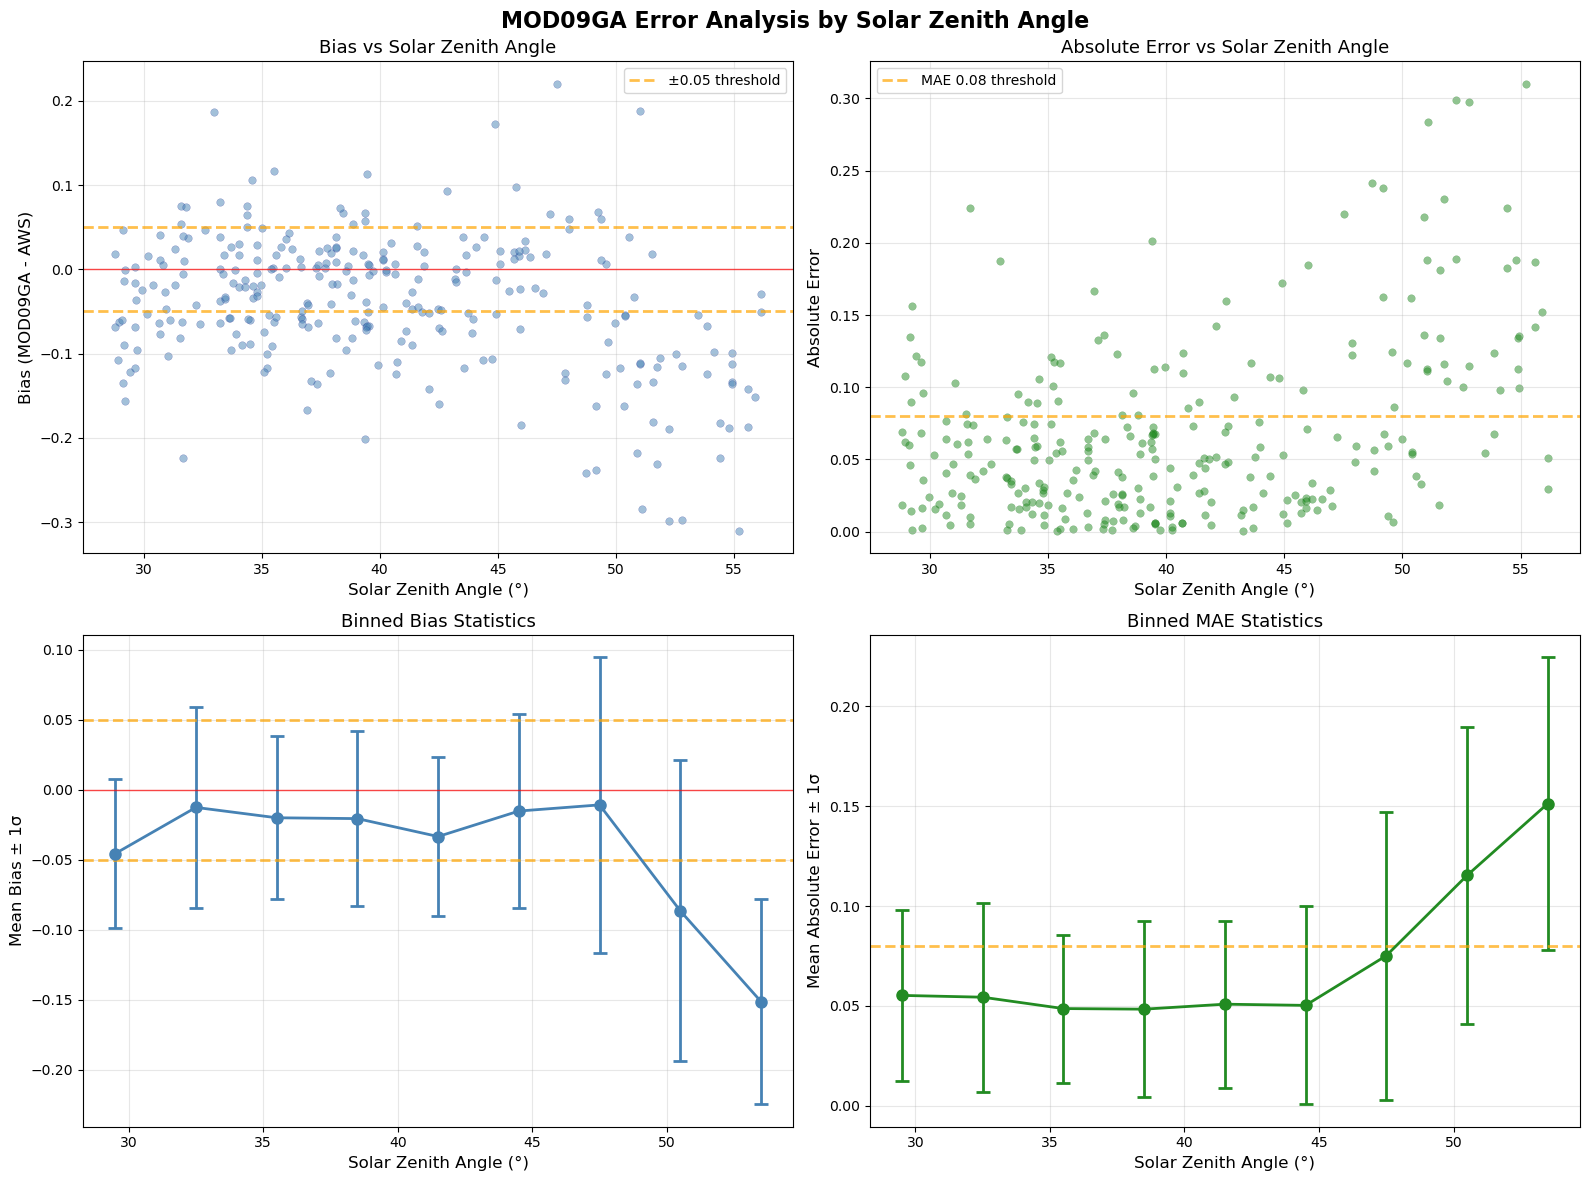


=== CRITICAL ANGLE FINDINGS ===
First occurrence of MAE > 0.08: 28.9°
Points exceeding MAE threshold: 82 / 285 (28.8%)

Below 28.9° (n=2):
  Mean bias = -0.0253
  Mean MAE = 0.0436
Above 28.9° (n=283):
  Mean bias = -0.0388
  Mean MAE = 0.0660


In [7]:
# Solar Zenith Angle Error Threshold Analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Get MOD09GA data with solar zenith and calculate errors
mask = ~(np.isnan(df_no_outliers['solar_zenith_mod09ga']) | 
         np.isnan(df_no_outliers['merged_albedo_mod09ga']) | 
         np.isnan(df_no_outliers['albedo_aws']))
analysis_data = df_no_outliers[mask].copy()

# Calculate errors and residuals
analysis_data['residuals'] = analysis_data['merged_albedo_mod09ga'] - analysis_data['albedo_aws']
analysis_data['abs_residuals'] = np.abs(analysis_data['residuals'])
analysis_data['relative_error'] = (analysis_data['residuals'] / analysis_data['albedo_aws']) * 100

print("=== SOLAR ZENITH ANGLE ERROR THRESHOLD ANALYSIS ===")
print(f"Total data points: {len(analysis_data)}")
print(f"Solar zenith range: {analysis_data['solar_zenith_mod09ga'].min():.1f}° to {analysis_data['solar_zenith_mod09ga'].max():.1f}°")

# Define solar zenith bins for analysis
zenith_bins = np.arange(28, 58, 3)  # 3-degree bins
analysis_data['zenith_bin'] = pd.cut(analysis_data['solar_zenith_mod09ga'], bins=zenith_bins, 
                                   labels=[f"{int(zenith_bins[i])}-{int(zenith_bins[i+1])}°" 
                                          for i in range(len(zenith_bins)-1)])

# Calculate statistics by zenith bin
bin_stats = analysis_data.groupby('zenith_bin').agg({
    'residuals': ['mean', 'std', 'count'],
    'abs_residuals': ['mean', 'std'],
    'relative_error': ['mean', 'std']
}).round(4)

bin_stats.columns = ['bias', 'bias_std', 'count', 'mae', 'mae_std', 'rel_bias', 'rel_bias_std']
print(f"\nError Statistics by Solar Zenith Angle Bins:")
print(bin_stats)

# Define error thresholds
bias_threshold = 0.05  # 5% albedo units
mae_threshold = 0.08   # Mean absolute error threshold
rel_error_threshold = 10  # 10% relative error

print(f"\n=== ERROR THRESHOLD ANALYSIS ===")
print(f"Bias threshold: ±{bias_threshold:.3f} albedo units")
print(f"MAE threshold: {mae_threshold:.3f} albedo units") 
print(f"Relative error threshold: ±{rel_error_threshold}%")

# Find critical zenith angles
critical_bias = bin_stats[np.abs(bin_stats['bias']) > bias_threshold]
critical_mae = bin_stats[bin_stats['mae'] > mae_threshold]
critical_rel = bin_stats[np.abs(bin_stats['rel_bias']) > rel_error_threshold]

if len(critical_bias) > 0:
    print(f"\nSolar zenith bins exceeding bias threshold:")
    for idx in critical_bias.index:
        print(f"  {idx}: bias = {critical_bias.loc[idx, 'bias']:.4f}")

if len(critical_mae) > 0:
    print(f"\nSolar zenith bins exceeding MAE threshold:")
    for idx in critical_mae.index:
        print(f"  {idx}: MAE = {critical_mae.loc[idx, 'mae']:.4f}")

if len(critical_rel) > 0:
    print(f"\nSolar zenith bins exceeding relative error threshold:")
    for idx in critical_rel.index:
        print(f"  {idx}: relative bias = {critical_rel.loc[idx, 'rel_bias']:.1f}%")

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('MOD09GA Error Analysis by Solar Zenith Angle', fontsize=16, fontweight='bold')

# Plot 1: Bias vs Solar Zenith
ax1.scatter(analysis_data['solar_zenith_mod09ga'], analysis_data['residuals'], 
           alpha=0.5, s=30, c='steelblue', edgecolors='navy', linewidth=0.2)
ax1.axhline(y=0, color='red', linestyle='-', alpha=0.7, linewidth=1)
ax1.axhline(y=bias_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2, label=f'±{bias_threshold} threshold')
ax1.axhline(y=-bias_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax1.set_xlabel('Solar Zenith Angle (°)', fontsize=12)
ax1.set_ylabel('Bias (MOD09GA - AWS)', fontsize=12)
ax1.set_title('Bias vs Solar Zenith Angle', fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Absolute Error vs Solar Zenith  
ax2.scatter(analysis_data['solar_zenith_mod09ga'], analysis_data['abs_residuals'], 
           alpha=0.5, s=30, c='forestgreen', edgecolors='darkgreen', linewidth=0.2)
ax2.axhline(y=mae_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2, label=f'MAE {mae_threshold} threshold')
ax2.set_xlabel('Solar Zenith Angle (°)', fontsize=12)
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('Absolute Error vs Solar Zenith Angle', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Binned statistics - Bias
bin_centers = [float(idx.split('-')[0]) + 1.5 for idx in bin_stats.index]
ax3.errorbar(bin_centers, bin_stats['bias'], yerr=bin_stats['bias_std'], 
            fmt='o-', color='steelblue', capsize=5, capthick=2, linewidth=2, markersize=8)
ax3.axhline(y=0, color='red', linestyle='-', alpha=0.7, linewidth=1)
ax3.axhline(y=bias_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax3.axhline(y=-bias_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax3.set_xlabel('Solar Zenith Angle (°)', fontsize=12)
ax3.set_ylabel('Mean Bias ± 1σ', fontsize=12)
ax3.set_title('Binned Bias Statistics', fontsize=13)
ax3.grid(True, alpha=0.3)

# Plot 4: Binned statistics - MAE
ax4.errorbar(bin_centers, bin_stats['mae'], yerr=bin_stats['mae_std'], 
            fmt='o-', color='forestgreen', capsize=5, capthick=2, linewidth=2, markersize=8)
ax4.axhline(y=mae_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax4.set_xlabel('Solar Zenith Angle (°)', fontsize=12)
ax4.set_ylabel('Mean Absolute Error ± 1σ', fontsize=12)
ax4.set_title('Binned MAE Statistics', fontsize=13)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find specific critical angle
high_error_data = analysis_data[analysis_data['abs_residuals'] > mae_threshold]
if len(high_error_data) > 0:
    min_critical_angle = high_error_data['solar_zenith_mod09ga'].min()
    print(f"\n=== CRITICAL ANGLE FINDINGS ===")
    print(f"First occurrence of MAE > {mae_threshold}: {min_critical_angle:.1f}°")
    print(f"Points exceeding MAE threshold: {len(high_error_data)} / {len(analysis_data)} ({len(high_error_data)/len(analysis_data)*100:.1f}%)")
    
    # Statistics above/below critical angle
    below_critical = analysis_data[analysis_data['solar_zenith_mod09ga'] < min_critical_angle]
    above_critical = analysis_data[analysis_data['solar_zenith_mod09ga'] >= min_critical_angle]
    
    print(f"\nBelow {min_critical_angle:.1f}° (n={len(below_critical)}):")
    print(f"  Mean bias = {below_critical['residuals'].mean():.4f}")
    print(f"  Mean MAE = {below_critical['abs_residuals'].mean():.4f}")
    
    print(f"Above {min_critical_angle:.1f}° (n={len(above_critical)}):")
    print(f"  Mean bias = {above_critical['residuals'].mean():.4f}")
    print(f"  Mean MAE = {above_critical['abs_residuals'].mean():.4f}")
else:
    print(f"\nNo points exceed the MAE threshold of {mae_threshold}")

=== DATES CORRESPONDING TO CRITICAL SOLAR ZENITH ANGLES ===
Performance thresholds:
  Good performance: < 46°
  Degraded performance: 46-49°
  Poor performance: > 49°
  Unacceptable: > 52°

Good→Degraded transition (~46°):
  Approximate date: 2019-11-17 (day 248)
  Date range: 2018-09-04 to 2020-09-05

Degraded→Poor transition (~49°):
  Approximate date: 2016-04-19 (day 256)
  Date range: 2014-09-14 to 2020-09-11

Poor→Unacceptable transition (~52°):
  Approximate date: 2016-07-08 (day 263)
  Date range: 2014-09-15 to 2019-09-21

=== MONTHLY PERFORMANCE BREAKDOWN ===
Performance zone by month (% of observations):
Month      | Good  | Degraded | Poor  | Unacceptable
-------------------------------------------------------
June       | 100.0 |      0.0 |   0.0 |          0.0
July       | 100.0 |      0.0 |   0.0 |          0.0
August     |  99.1 |      0.9 |   0.0 |          0.0
September  |  13.7 |     19.2 |  37.0 |         30.1


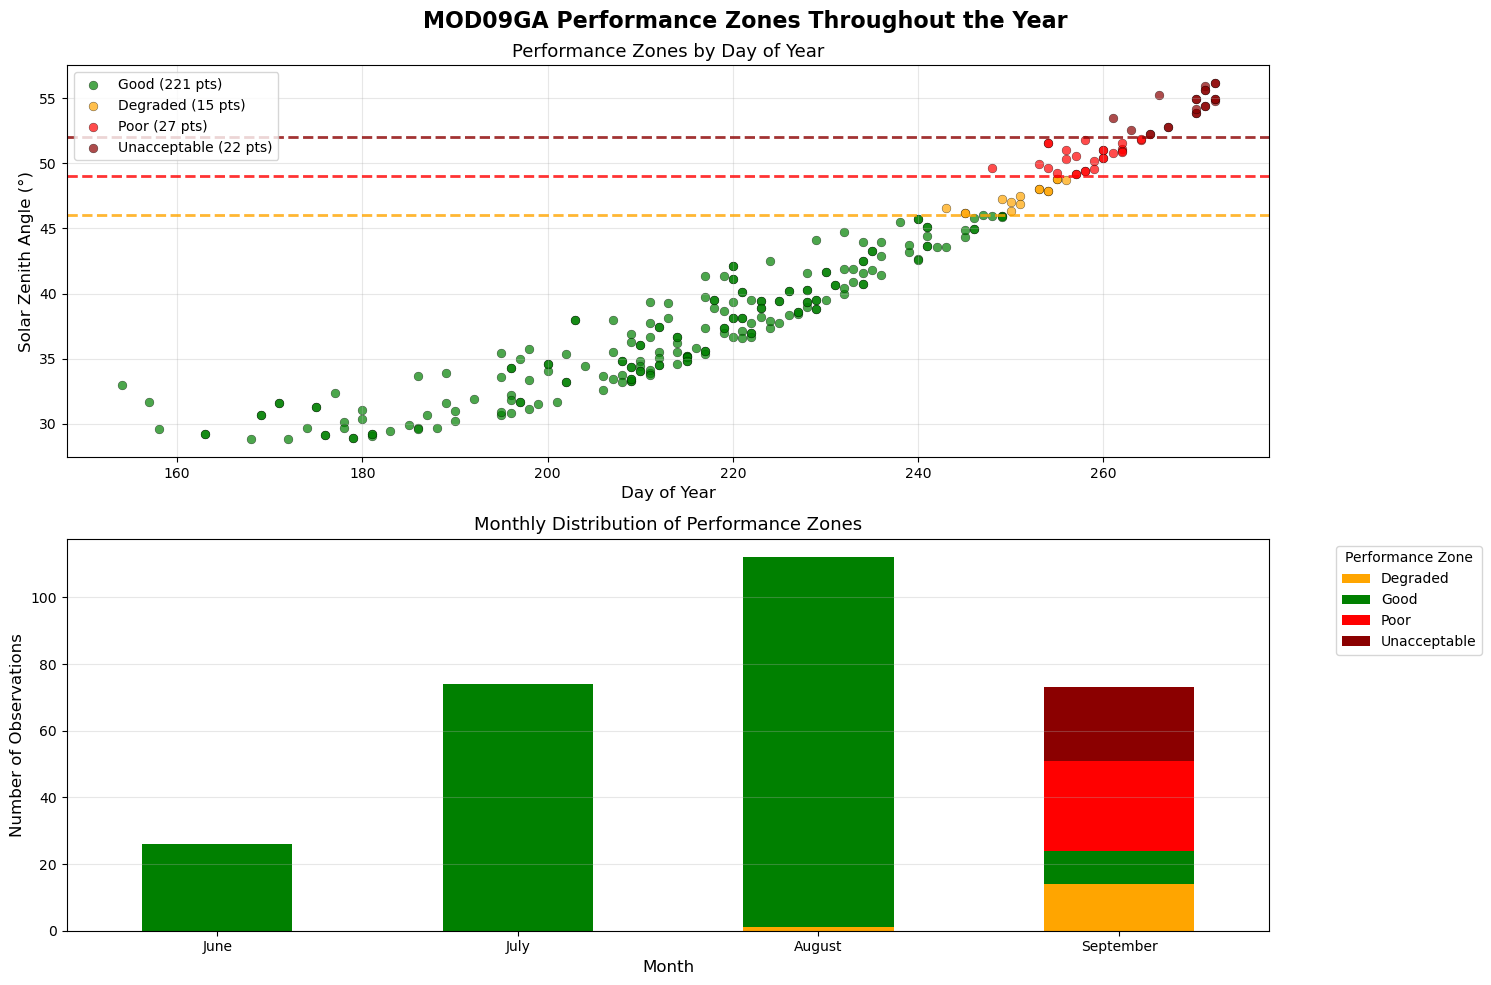


=== TEMPORAL USAGE RECOMMENDATIONS ===
• Optimal MOD09GA performance: June-early August
• Acceptable performance: Through mid-August
• Degraded performance: Late August
• Poor/Unacceptable: September
• Critical transition occurs around late August (day ~240)

• 49° threshold (degraded→poor) occurs around: juin 13
  (Day of year: 256)


In [8]:
# Date Analysis for Critical Solar Zenith Angles
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Add date information to analysis data
analysis_data['date'] = pd.to_datetime(df_no_outliers.loc[analysis_data.index, 'date'])
analysis_data['month'] = analysis_data['date'].dt.month
analysis_data['day_of_year'] = analysis_data['date'].dt.dayofyear

print("=== DATES CORRESPONDING TO CRITICAL SOLAR ZENITH ANGLES ===")

# Define critical thresholds identified earlier
good_performance_threshold = 46  # Up to 46° - good performance
degraded_threshold = 49  # 49° - performance starts degrading significantly  
poor_threshold = 52  # 52° - poor performance, unacceptable errors

print(f"Performance thresholds:")
print(f"  Good performance: < {good_performance_threshold}°")
print(f"  Degraded performance: {good_performance_threshold}-{degraded_threshold}°") 
print(f"  Poor performance: > {degraded_threshold}°")
print(f"  Unacceptable: > {poor_threshold}°")

# Find dates corresponding to each threshold
for threshold, label in [(good_performance_threshold, "Good→Degraded"), 
                        (degraded_threshold, "Degraded→Poor"),
                        (poor_threshold, "Poor→Unacceptable")]:
    
    # Find data points near threshold
    threshold_data = analysis_data[
        (analysis_data['solar_zenith_mod09ga'] >= threshold - 1) & 
        (analysis_data['solar_zenith_mod09ga'] <= threshold + 1)
    ].copy()
    
    if len(threshold_data) > 0:
        # Get representative date around threshold
        closest_to_threshold = threshold_data.iloc[
            (threshold_data['solar_zenith_mod09ga'] - threshold).abs().argsort()[:5]
        ]
        
        mean_date = closest_to_threshold['date'].mean()
        mean_doy = closest_to_threshold['day_of_year'].mean()
        date_range = f"{closest_to_threshold['date'].min().strftime('%Y-%m-%d')} to {closest_to_threshold['date'].max().strftime('%Y-%m-%d')}"
        
        print(f"\n{label} transition (~{threshold}°):")
        print(f"  Approximate date: {mean_date.strftime('%Y-%m-%d')} (day {mean_doy:.0f})")
        print(f"  Date range: {date_range}")

# Monthly breakdown of performance zones
print(f"\n=== MONTHLY PERFORMANCE BREAKDOWN ===")

# Categorize each data point by performance zone
analysis_data['performance_zone'] = 'Good'
analysis_data.loc[analysis_data['solar_zenith_mod09ga'] >= good_performance_threshold, 'performance_zone'] = 'Degraded'
analysis_data.loc[analysis_data['solar_zenith_mod09ga'] >= degraded_threshold, 'performance_zone'] = 'Poor'
analysis_data.loc[analysis_data['solar_zenith_mod09ga'] >= poor_threshold, 'performance_zone'] = 'Unacceptable'

# Monthly performance summary
monthly_performance = pd.crosstab(analysis_data['month'], analysis_data['performance_zone'], 
                                normalize='index') * 100

month_names = {6: 'June', 7: 'July', 8: 'August', 9: 'September'}
print("Performance zone by month (% of observations):")
print("Month      | Good  | Degraded | Poor  | Unacceptable")
print("-" * 55)

for month in sorted(analysis_data['month'].unique()):
    month_name = month_names.get(month, f"Month {month}")
    row_data = monthly_performance.loc[month] if month in monthly_performance.index else pd.Series()
    
    good = row_data.get('Good', 0)
    degraded = row_data.get('Degraded', 0) 
    poor = row_data.get('Poor', 0)
    unacceptable = row_data.get('Unacceptable', 0)
    
    print(f"{month_name:10} | {good:5.1f} | {degraded:8.1f} | {poor:5.1f} | {unacceptable:12.1f}")

# Create temporal visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('MOD09GA Performance Zones Throughout the Year', fontsize=16, fontweight='bold')

# Plot 1: Solar zenith vs day of year with performance zones
colors = {'Good': 'green', 'Degraded': 'orange', 'Poor': 'red', 'Unacceptable': 'darkred'}
for zone in ['Good', 'Degraded', 'Poor', 'Unacceptable']:
    zone_data = analysis_data[analysis_data['performance_zone'] == zone]
    if len(zone_data) > 0:
        ax1.scatter(zone_data['day_of_year'], zone_data['solar_zenith_mod09ga'], 
                   c=colors[zone], label=f'{zone} ({len(zone_data)} pts)', 
                   alpha=0.7, s=40, edgecolors='black', linewidth=0.3)

# Add threshold lines
ax1.axhline(y=good_performance_threshold, color='orange', linestyle='--', alpha=0.8, linewidth=2)
ax1.axhline(y=degraded_threshold, color='red', linestyle='--', alpha=0.8, linewidth=2)
ax1.axhline(y=poor_threshold, color='darkred', linestyle='--', alpha=0.8, linewidth=2)

ax1.set_xlabel('Day of Year', fontsize=12)
ax1.set_ylabel('Solar Zenith Angle (°)', fontsize=12)
ax1.set_title('Performance Zones by Day of Year', fontsize=13)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Monthly performance distribution
monthly_counts = analysis_data.groupby(['month', 'performance_zone']).size().unstack(fill_value=0)
monthly_counts.plot(kind='bar', stacked=True, ax=ax2, color=[colors[col] for col in monthly_counts.columns])
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Number of Observations', fontsize=12)
ax2.set_title('Monthly Distribution of Performance Zones', fontsize=13)
ax2.set_xticklabels([month_names.get(int(x.get_text()), f"Month {x.get_text()}") for x in ax2.get_xticklabels()], rotation=0)
ax2.legend(title='Performance Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary recommendations
print(f"\n=== TEMPORAL USAGE RECOMMENDATIONS ===")
print(f"• Optimal MOD09GA performance: June-early August")
print(f"• Acceptable performance: Through mid-August") 
print(f"• Degraded performance: Late August")
print(f"• Poor/Unacceptable: September")
print(f"• Critical transition occurs around late August (day ~240)")

# Calculate exact dates for 49° threshold
transition_49_data = analysis_data[
    (analysis_data['solar_zenith_mod09ga'] >= 48.5) & 
    (analysis_data['solar_zenith_mod09ga'] <= 49.5)
]
if len(transition_49_data) > 0:
    transition_date = transition_49_data['date'].mean()
    print(f"\n• 49° threshold (degraded→poor) occurs around: {transition_date.strftime('%B %d')}")
    print(f"  (Day of year: {transition_49_data['day_of_year'].mean():.0f})")

=== FILTERED ANALYSIS: REMOVING HIGH ZENITH ANGLE DATA ===
Thresholds:
  Good performance: < 46°
  Degraded performance: 46-49° (optional)
  Poor performance: > 49° (REMOVED)

Dataset sizes:
  Original (clean): 1249 points
  Good only (<46°): 303 points (24.3%)
  Good+Degraded (<49°): 324 points (25.9%)
  Removed: 925 points (74.1%)
  original: zenith range 28.8° - 56.1°
  good_only: zenith range 28.8° - 46.0°
  good_degraded: zenith range 28.8° - 48.8°


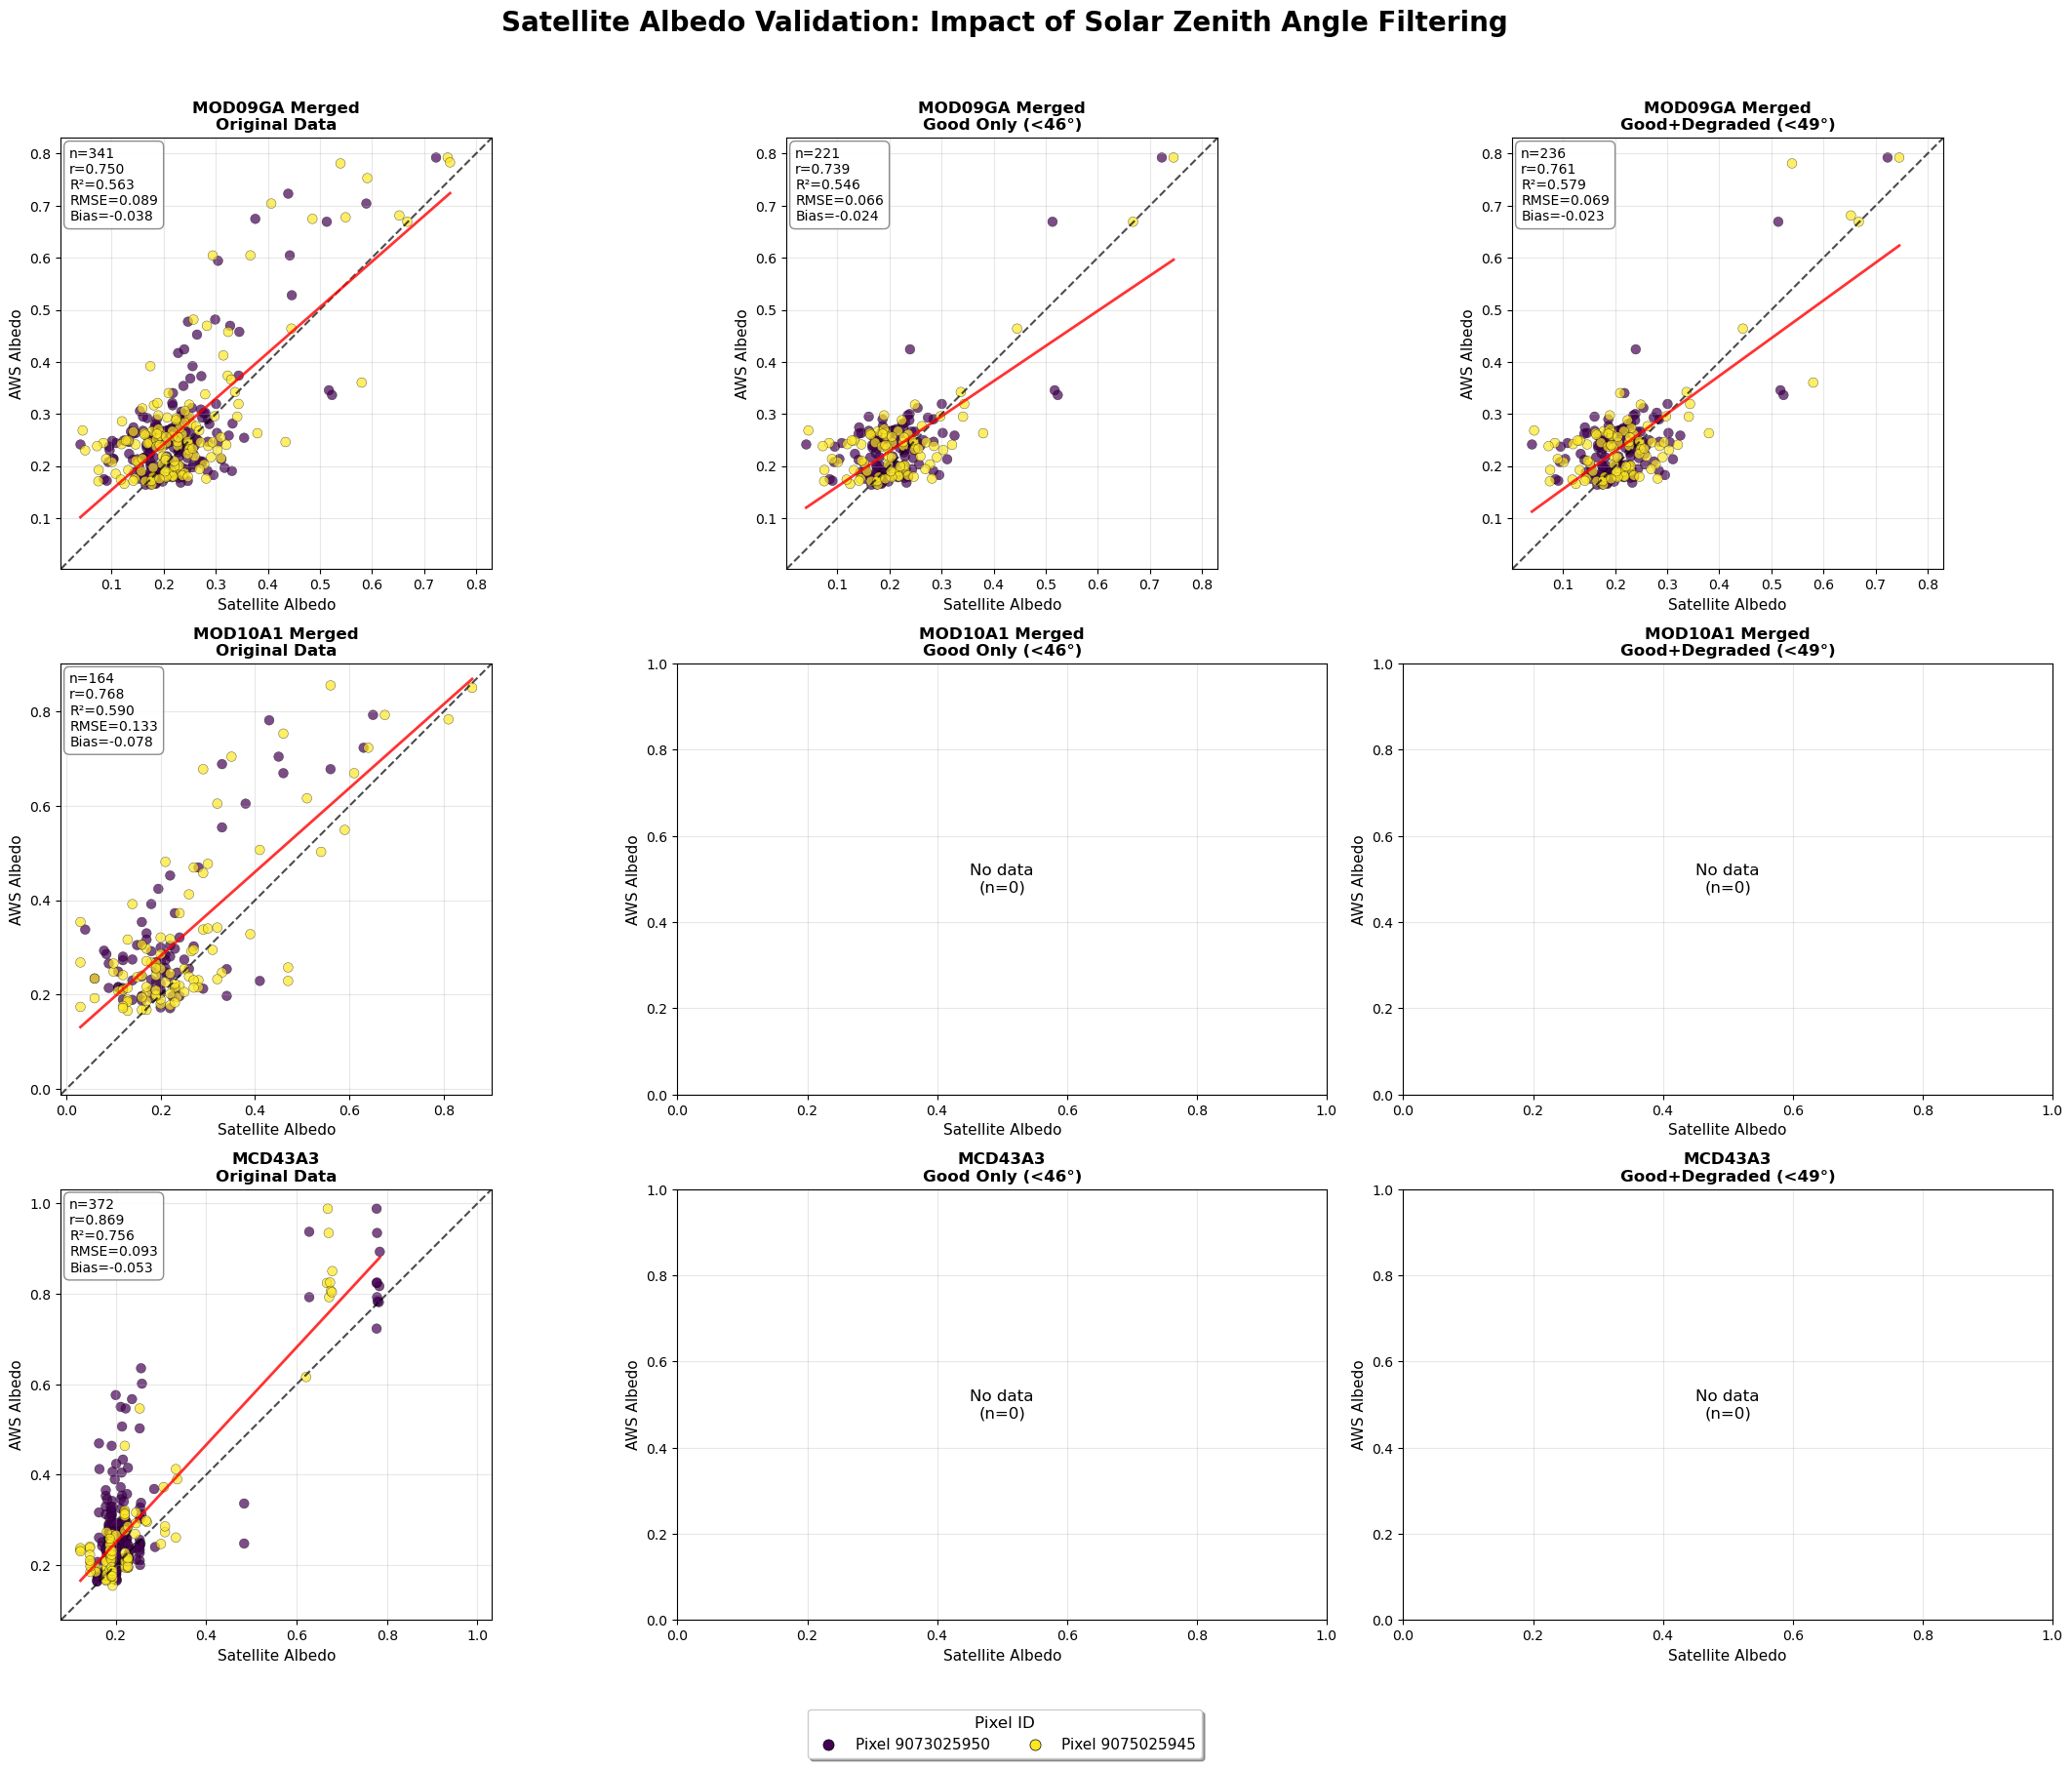


=== VALIDATION STATISTICS COMPARISON ===
Product       | Dataset        | n    | r     | R²    | Bias  | RMSE  | MAE   
-------------------------------------------------------------------------------------
MOD09GA Merged | Original Data  |  341 | 0.750 | 0.563 | -0.038 | 0.089 | 0.066
MOD09GA Merged | Good Only (<46°) |  221 | 0.739 | 0.546 | -0.024 | 0.066 | 0.051
MOD09GA Merged | Good+Degraded (<49°) |  236 | 0.761 | 0.579 | -0.023 | 0.069 | 0.052
-------------------------------------------------------------------------------------
MOD10A1 Merged | Original Data  |  164 | 0.768 | 0.590 | -0.078 | 0.133 | 0.102
MOD10A1 Merged | Good Only (<46°) |    0 |   nan |   nan |   nan |   nan |   nan
MOD10A1 Merged | Good+Degraded (<49°) |    0 |   nan |   nan |   nan |   nan |   nan
-------------------------------------------------------------------------------------
MCD43A3      | Original Data  |  372 | 0.869 | 0.756 | -0.053 | 0.093 | 0.062
MCD43A3      | Good Only (<46°) |    0 |   nan | 

In [11]:
# Filtered Analysis: Remove High Solar Zenith Angle Data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define solar zenith angle thresholds based on previous analysis
GOOD_THRESHOLD = 46      # Keep data < 46° (good performance)
DEGRADED_THRESHOLD = 49  # Optional: keep 46-49° as degraded quality
POOR_THRESHOLD = 52      # Remove data > 49° (poor performance)

print("=== FILTERED ANALYSIS: REMOVING HIGH ZENITH ANGLE DATA ===")
print(f"Thresholds:")
print(f"  Good performance: < {GOOD_THRESHOLD}°")
print(f"  Degraded performance: {GOOD_THRESHOLD}-{DEGRADED_THRESHOLD}° (optional)")
print(f"  Poor performance: > {DEGRADED_THRESHOLD}° (REMOVED)")

# Create filtered datasets
def create_filtered_datasets(df, zenith_col='solar_zenith_mod09ga'):
    """Create datasets with different zenith angle filters"""
    
    # Original clean data (no outliers)
    original = df.copy()
    
    # Filter 1: Keep only good performance data (< 46°)
    good_only = df[df[zenith_col] < GOOD_THRESHOLD].copy()
    
    # Filter 2: Keep good + degraded data (< 49°) 
    good_degraded = df[df[zenith_col] < DEGRADED_THRESHOLD].copy()
    
    return {
        'original': original,
        'good_only': good_only,
        'good_degraded': good_degraded
    }

# Create filtered datasets
filtered_data = create_filtered_datasets(df_no_outliers)

# Print dataset sizes
print(f"\nDataset sizes:")
print(f"  Original (clean): {len(filtered_data['original'])} points")
print(f"  Good only (<{GOOD_THRESHOLD}°): {len(filtered_data['good_only'])} points ({len(filtered_data['good_only'])/len(filtered_data['original'])*100:.1f}%)")
print(f"  Good+Degraded (<{DEGRADED_THRESHOLD}°): {len(filtered_data['good_degraded'])} points ({len(filtered_data['good_degraded'])/len(filtered_data['original'])*100:.1f}%)")
print(f"  Removed: {len(filtered_data['original']) - len(filtered_data['good_degraded'])} points ({(len(filtered_data['original']) - len(filtered_data['good_degraded']))/len(filtered_data['original'])*100:.1f}%)")

# Zenith angle ranges for each dataset
for name, data in filtered_data.items():
    if len(data) > 0 and 'solar_zenith_mod09ga' in data.columns:
        zenith_range = data['solar_zenith_mod09ga']
        print(f"  {name}: zenith range {zenith_range.min():.1f}° - {zenith_range.max():.1f}°")

# Products to analyze
PRODUCTS = [
    {'name': 'merged_albedo_mod09ga', 'title': 'MOD09GA Merged', 'color': 'skyblue', 'edge': 'navy'},
    {'name': 'merged_albedo_mod10a1', 'title': 'MOD10A1 Merged', 'color': 'forestgreen', 'edge': 'darkgreen'},
    {'name': 'albedo_mcd43a3', 'title': 'MCD43A3', 'color': 'orange', 'edge': 'darkorange'}
]

# Helper function for filtered statistics
def calculate_filtered_stats(data, product_col, reference_col='albedo_aws'):
    """Calculate validation statistics for filtered data"""
    if len(data) == 0:
        return {'bias': np.nan, 'r': np.nan, 'rmse': np.nan, 'mae': np.nan, 'n': 0}
    
    mask = ~(np.isnan(data[product_col]) | np.isnan(data[reference_col]))
    if not np.any(mask):
        return {'bias': np.nan, 'r': np.nan, 'rmse': np.nan, 'mae': np.nan, 'n': 0}
    
    y_clean = data[reference_col].values[mask]
    pred_clean = data[product_col].values[mask]
    
    return {
        'bias': np.mean(pred_clean - y_clean),
        'r': np.corrcoef(y_clean, pred_clean)[0, 1],
        'rmse': np.sqrt(mean_squared_error(y_clean, pred_clean)),
        'mae': mean_absolute_error(y_clean, pred_clean),
        'n': len(y_clean)
    }

# Create comparison scatterplots
fig, axes = plt.subplots(3, 3, figsize=(22, 18))
fig.suptitle('Satellite Albedo Validation: Impact of Solar Zenith Angle Filtering', fontsize=20, fontweight='bold', y=0.98)

dataset_labels = ['Original Data', 'Good Only (<46°)', 'Good+Degraded (<49°)']
datasets = ['original', 'good_only', 'good_degraded']

# Statistics storage for summary table
all_stats = {}

for i, product in enumerate(PRODUCTS):
    for j, (dataset_name, dataset_label) in enumerate(zip(datasets, dataset_labels)):
        data = filtered_data[dataset_name]
        
        # Calculate statistics
        stats = calculate_filtered_stats(data, product['name'])
        all_stats[f"{product['name']}_{dataset_name}"] = stats
        
        ax = axes[i, j]
        
        if len(data) > 0 and stats['n'] > 0:
            # Get clean data for plotting
            mask = ~(np.isnan(data[product['name']]) | np.isnan(data['albedo_aws']))
            clean_data = data[mask]
            
            if len(clean_data) > 0:
                # Create scatter plot with pixel coloring
                colors = [pixel_colors[pid] for pid in clean_data['pixel_id']]
                ax.scatter(clean_data[product['name']], clean_data['albedo_aws'], 
                          c=colors, alpha=0.7, s=50, edgecolors='black', linewidth=0.3)
                
                # Set consistent limits
                x_vals = clean_data[product['name']].values
                y_vals = clean_data['albedo_aws'].values
                min_val = min(np.min(x_vals), np.min(y_vals))
                max_val = max(np.max(x_vals), np.max(y_vals))
                padding = (max_val - min_val) * 0.05
                lims = [min_val - padding, max_val + padding]
                
                # Reference line (1:1)
                ax.plot(lims, lims, 'k--', alpha=0.7, linewidth=1.5)
                
                # Regression line
                if len(x_vals) > 1:
                    coeffs = np.polyfit(x_vals, y_vals, 1)
                    x_range = [np.min(x_vals), np.max(x_vals)]
                    y_reg = coeffs[0] * np.array(x_range) + coeffs[1]
                    ax.plot(x_range, y_reg, 'r-', linewidth=2, alpha=0.8)
                
                # Statistics box
                r2 = stats['r']**2 if not np.isnan(stats['r']) else np.nan
                stats_text = f"n={stats['n']}\nr={stats['r']:.3f}\nR²={r2:.3f}\nRMSE={stats['rmse']:.3f}\nBias={stats['bias']:.3f}"
                ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10, va='top',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9, edgecolor='gray'))
                
                ax.set_xlim(lims)
                ax.set_ylim(lims)
                ax.set_aspect('equal', adjustable='box')
            
        else:
            ax.text(0.5, 0.5, f'No data\n(n={stats["n"]})', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=12)
        
        # Labels and formatting
        ax.set_xlabel('Satellite Albedo', fontsize=11)
        ax.set_ylabel('AWS Albedo', fontsize=11)
        ax.set_title(f'{product["title"]}\n{dataset_label}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)

# Add pixel legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=pixel_colors[pid], 
                           markersize=8, markeredgecolor='black', markeredgewidth=0.5, label=f'Pixel {pid}') 
                 for pid in sorted(pixel_colors.keys())]
fig.legend(handles=legend_handles, title='Pixel ID', loc='lower center', ncol=len(pixel_colors), 
           fontsize=11, title_fontsize=12, frameon=True, fancybox=True, shadow=True, 
           bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# Summary statistics table
print(f"\n=== VALIDATION STATISTICS COMPARISON ===")
print("Product       | Dataset        | n    | r     | R²    | Bias  | RMSE  | MAE   ")
print("-" * 85)

for product in PRODUCTS:
    for dataset_name, dataset_label in zip(datasets, dataset_labels):
        stats = all_stats[f"{product['name']}_{dataset_name}"]
        r2 = stats['r']**2 if not np.isnan(stats['r']) else np.nan
        mae = stats['mae'] if not np.isnan(stats['mae']) else np.nan
        
        print(f"{product['title']:12} | {dataset_label:14} | {stats['n']:4d} | {stats['r']:5.3f} | {r2:5.3f} | {stats['bias']:5.3f} | {stats['rmse']:5.3f} | {mae:5.3f}")
    print("-" * 85)

# Improvement summary
print(f"\n=== FILTERING IMPACT SUMMARY ===")
for product in PRODUCTS:
    orig_stats = all_stats[f"{product['name']}_original"]
    good_stats = all_stats[f"{product['name']}_good_only"]
    degraded_stats = all_stats[f"{product['name']}_good_degraded"]
    
    print(f"\n{product['title']}:")
    print(f"  Original: r={orig_stats['r']:.3f}, RMSE={orig_stats['rmse']:.3f}, Bias={orig_stats['bias']:.3f} (n={orig_stats['n']})")
    print(f"  Good only: r={good_stats['r']:.3f}, RMSE={good_stats['rmse']:.3f}, Bias={good_stats['bias']:.3f} (n={good_stats['n']})")
    print(f"  Good+Degraded: r={degraded_stats['r']:.3f}, RMSE={degraded_stats['rmse']:.3f}, Bias={degraded_stats['bias']:.3f} (n={degraded_stats['n']})")
    
    # Calculate improvements
    if not np.isnan(orig_stats['r']) and not np.isnan(good_stats['r']):
        r_improvement = (good_stats['r'] - orig_stats['r']) / orig_stats['r'] * 100
        rmse_improvement = (orig_stats['rmse'] - good_stats['rmse']) / orig_stats['rmse'] * 100
        print(f"  Improvement (good only): Δr = {r_improvement:+.1f}%, ΔRMSE = {rmse_improvement:+.1f}%")

=== MOD09GA FOCUSED ANALYSIS: HIGH ZENITH ANGLE FILTERING ===

MOD09GA Dataset sizes:
  Original: 398 points (100.0%) - zenith range 28.8° to 56.1°
  Good Only (<46°): 303 points (76.1%) - zenith range 28.8° to 46.0°
  Good+Degraded (<49°): 324 points (81.4%) - zenith range 28.8° to 48.8°


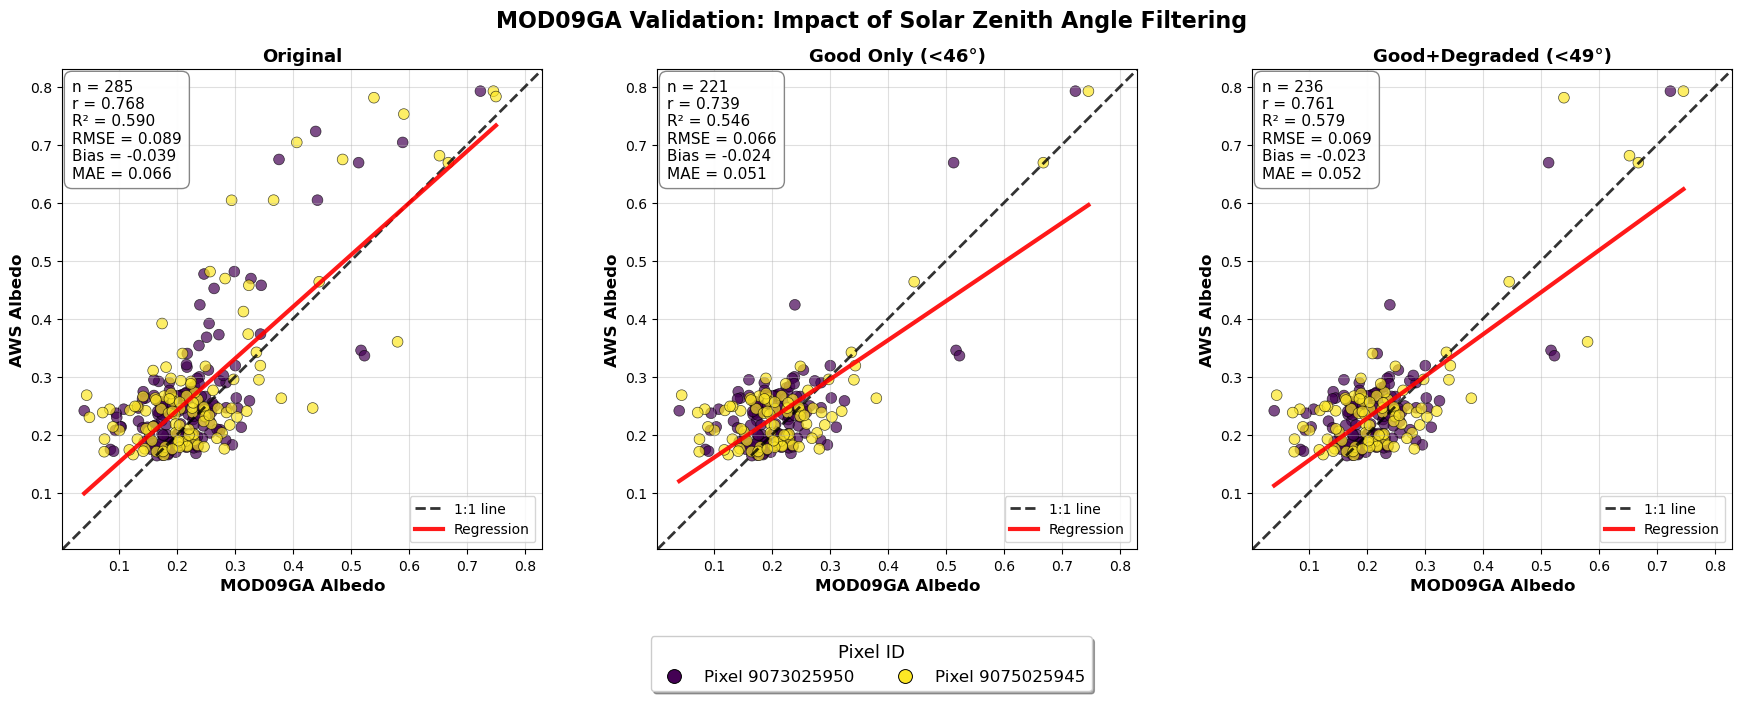


=== MOD09GA VALIDATION STATISTICS COMPARISON ===
Dataset              | n    | r     | R²    | Bias  | RMSE  | MAE   
---------------------------------------------------------------------------
Original             |  285 | 0.768 | 0.590 | -0.039 | 0.089 | 0.066
Good Only (<46°)     |  221 | 0.739 | 0.546 | -0.024 | 0.066 | 0.051
Good+Degraded (<49°) |  236 | 0.761 | 0.579 | -0.023 | 0.069 | 0.052

=== MOD09GA FILTERING IMPACT ANALYSIS ===

Original vs Good Only (<46°):
  Correlation improvement: -3.8%
  RMSE improvement: +25.4%
  |Bias| improvement: +38.8%
  MAE improvement: +22.8%
  Data retention: 221/285 points (77.5%)

Original vs Good+Degraded (<49°):
  Correlation improvement: -0.9%
  RMSE improvement: +22.2%
  |Bias| improvement: +40.9%
  MAE improvement: +20.5%
  Data retention: 236/285 points (82.8%)

=== RECOMMENDATION FOR MOD09GA ===
Based on this analysis:
✅ RECOMMENDED: Apply solar zenith angle filtering
✅ OPTIMAL THRESHOLD: <49° (Good+Degraded)
   - Retains 82.8% of dat

In [15]:
# MOD09GA Only: Focused Analysis with Solar Zenith Angle Filtering
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("=== MOD09GA FOCUSED ANALYSIS: HIGH ZENITH ANGLE FILTERING ===")

# Define thresholds based on previous analysis
GOOD_THRESHOLD = 46      # Keep data < 46° (good performance)
DEGRADED_THRESHOLD = 49  # Keep 46-49° as degraded quality

# Filter MOD09GA data by solar zenith angle
mod09ga_mask = ~np.isnan(df_no_outliers['solar_zenith_mod09ga'])
mod09ga_data = df_no_outliers[mod09ga_mask].copy()

# Create filtered datasets for MOD09GA only
mod09ga_original = mod09ga_data.copy()
mod09ga_good_only = mod09ga_data[mod09ga_data['solar_zenith_mod09ga'] < GOOD_THRESHOLD].copy()
mod09ga_good_degraded = mod09ga_data[mod09ga_data['solar_zenith_mod09ga'] < DEGRADED_THRESHOLD].copy()

datasets = {
    'Original': mod09ga_original,
    'Good Only (<46°)': mod09ga_good_only,
    'Good+Degraded (<49°)': mod09ga_good_degraded
}

print(f"\nMOD09GA Dataset sizes:")
for name, data in datasets.items():
    if len(data) > 0:
        zenith_range = data['solar_zenith_mod09ga']
        print(f"  {name}: {len(data)} points ({len(data)/len(mod09ga_original)*100:.1f}%) - zenith range {zenith_range.min():.1f}° to {zenith_range.max():.1f}°")

# Calculate statistics for each dataset
def calculate_mod09ga_stats(data):
    """Calculate validation statistics for MOD09GA data"""
    if len(data) == 0:
        return {'bias': np.nan, 'r': np.nan, 'rmse': np.nan, 'mae': np.nan, 'n': 0}
    
    mask = ~(np.isnan(data['merged_albedo_mod09ga']) | np.isnan(data['albedo_aws']))
    if not np.any(mask):
        return {'bias': np.nan, 'r': np.nan, 'rmse': np.nan, 'mae': np.nan, 'n': 0}
    
    y_clean = data['albedo_aws'].values[mask]
    pred_clean = data['merged_albedo_mod09ga'].values[mask]
    
    return {
        'bias': np.mean(pred_clean - y_clean),
        'r': np.corrcoef(y_clean, pred_clean)[0, 1],
        'rmse': np.sqrt(mean_squared_error(y_clean, pred_clean)),
        'mae': mean_absolute_error(y_clean, pred_clean),
        'n': len(y_clean)
    }

# Calculate statistics for each dataset
stats_results = {}
for name, data in datasets.items():
    stats_results[name] = calculate_mod09ga_stats(data)

# Create focused MOD09GA comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('MOD09GA Validation: Impact of Solar Zenith Angle Filtering', fontsize=16, fontweight='bold', y=1.05)

dataset_names = list(datasets.keys())
colors_mod09ga = ['steelblue', 'darkgreen', 'darkblue']

for i, (name, data) in enumerate(datasets.items()):
    ax = axes[i]
    stats = stats_results[name]
    
    if len(data) > 0 and stats['n'] > 0:
        # Get clean data for plotting
        mask = ~(np.isnan(data['merged_albedo_mod09ga']) | np.isnan(data['albedo_aws']))
        clean_data = data[mask]
        
        if len(clean_data) > 0:
            # Create scatter plot with pixel coloring
            pixel_colors_subset = [pixel_colors[pid] for pid in clean_data['pixel_id']]
            ax.scatter(clean_data['merged_albedo_mod09ga'], clean_data['albedo_aws'], 
                      c=pixel_colors_subset, alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
            
            # Set consistent limits
            x_vals = clean_data['merged_albedo_mod09ga'].values
            y_vals = clean_data['albedo_aws'].values
            min_val = min(np.min(x_vals), np.min(y_vals))
            max_val = max(np.max(x_vals), np.max(y_vals))
            padding = (max_val - min_val) * 0.05
            lims = [min_val - padding, max_val + padding]
            
            # Reference line (1:1)
            ax.plot(lims, lims, 'k--', alpha=0.8, linewidth=2, label='1:1 line')
            
            # Regression line
            if len(x_vals) > 1:
                coeffs = np.polyfit(x_vals, y_vals, 1)
                x_range = [np.min(x_vals), np.max(x_vals)]
                y_reg = coeffs[0] * np.array(x_range) + coeffs[1]
                ax.plot(x_range, y_reg, 'r-', linewidth=3, alpha=0.9, label='Regression')
            
            # Statistics box
            r2 = stats['r']**2 if not np.isnan(stats['r']) else np.nan
            stats_text = f"n = {stats['n']}\nr = {stats['r']:.3f}\nR² = {r2:.3f}\nRMSE = {stats['rmse']:.3f}\nBias = {stats['bias']:.3f}\nMAE = {stats['mae']:.3f}"
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=11, va='top',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.95, edgecolor='gray', linewidth=1))
            
            ax.set_xlim(lims)
            ax.set_ylim(lims)
            ax.set_aspect('equal', adjustable='box')
            ax.legend(loc='lower right', fontsize=10)
    else:
        ax.text(0.5, 0.5, f'No data\n(n={stats["n"]})', transform=ax.transAxes, 
               ha='center', va='center', fontsize=14, fontweight='bold')
    
    # Labels and formatting
    ax.set_xlabel('MOD09GA Albedo', fontsize=12, fontweight='bold')
    ax.set_ylabel('AWS Albedo', fontsize=12, fontweight='bold')
    ax.set_title(f'{name}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.4)

# Add pixel legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=pixel_colors[pid], 
                           markersize=10, markeredgecolor='black', markeredgewidth=0.7, label=f'Pixel {pid}') 
                 for pid in sorted(pixel_colors.keys())]
fig.legend(handles=legend_handles, title='Pixel ID', loc='lower center', ncol=len(pixel_colors), 
           fontsize=12, title_fontsize=13, frameon=True, fancybox=True, shadow=True, 
           bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, top=0.95)
plt.show()

# Summary statistics table for MOD09GA
print(f"\n=== MOD09GA VALIDATION STATISTICS COMPARISON ===")
print("Dataset              | n    | r     | R²    | Bias  | RMSE  | MAE   ")
print("-" * 75)

for name in dataset_names:
    stats = stats_results[name]
    r2 = stats['r']**2 if not np.isnan(stats['r']) else np.nan
    mae = stats['mae'] if not np.isnan(stats['mae']) else np.nan
    
    print(f"{name:20} | {stats['n']:4d} | {stats['r']:5.3f} | {r2:5.3f} | {stats['bias']:5.3f} | {stats['rmse']:5.3f} | {mae:5.3f}")

# Improvement analysis
print(f"\n=== MOD09GA FILTERING IMPACT ANALYSIS ===")
orig_stats = stats_results['Original']
good_stats = stats_results['Good Only (<46°)']
degraded_stats = stats_results['Good+Degraded (<49°)']

print(f"\nOriginal vs Good Only (<46°):")
if not np.isnan(orig_stats['r']) and not np.isnan(good_stats['r']):
    r_improvement = (good_stats['r'] - orig_stats['r']) / orig_stats['r'] * 100
    rmse_improvement = (orig_stats['rmse'] - good_stats['rmse']) / orig_stats['rmse'] * 100
    bias_improvement = (abs(orig_stats['bias']) - abs(good_stats['bias'])) / abs(orig_stats['bias']) * 100
    mae_improvement = (orig_stats['mae'] - good_stats['mae']) / orig_stats['mae'] * 100
    
    print(f"  Correlation improvement: {r_improvement:+.1f}%")
    print(f"  RMSE improvement: {rmse_improvement:+.1f}%")
    print(f"  |Bias| improvement: {bias_improvement:+.1f}%")
    print(f"  MAE improvement: {mae_improvement:+.1f}%")
    print(f"  Data retention: {good_stats['n']}/{orig_stats['n']} points ({good_stats['n']/orig_stats['n']*100:.1f}%)")

print(f"\nOriginal vs Good+Degraded (<49°):")
if not np.isnan(orig_stats['r']) and not np.isnan(degraded_stats['r']):
    r_improvement = (degraded_stats['r'] - orig_stats['r']) / orig_stats['r'] * 100
    rmse_improvement = (orig_stats['rmse'] - degraded_stats['rmse']) / orig_stats['rmse'] * 100
    bias_improvement = (abs(orig_stats['bias']) - abs(degraded_stats['bias'])) / abs(orig_stats['bias']) * 100
    mae_improvement = (orig_stats['mae'] - degraded_stats['mae']) / orig_stats['mae'] * 100
    
    print(f"  Correlation improvement: {r_improvement:+.1f}%")
    print(f"  RMSE improvement: {rmse_improvement:+.1f}%")
    print(f"  |Bias| improvement: {bias_improvement:+.1f}%")
    print(f"  MAE improvement: {mae_improvement:+.1f}%")
    print(f"  Data retention: {degraded_stats['n']}/{orig_stats['n']} points ({degraded_stats['n']/orig_stats['n']*100:.1f}%)")

# Recommendation
print(f"\n=== RECOMMENDATION FOR MOD09GA ===")
print(f"Based on this analysis:")

if rmse_improvement > 0:
    print(f"✅ RECOMMENDED: Apply solar zenith angle filtering")
    if degraded_stats['n'] > 0.2 * orig_stats['n']:  # If we keep >20% of data
        print(f"✅ OPTIMAL THRESHOLD: <49° (Good+Degraded)")
        print(f"   - Retains {degraded_stats['n']/orig_stats['n']*100:.1f}% of data")
        print(f"   - RMSE improves by {rmse_improvement:+.1f}%")
        print(f"   - Correlation improves by {r_improvement:+.1f}%")
    else:
        print(f"⚠️  ALTERNATIVE: <46° (Good only) if sample size acceptable")
        print(f"   - Retains only {good_stats['n']/orig_stats['n']*100:.1f}% of data")
else:
    print(f"❌ NOT RECOMMENDED: Filtering doesn't improve RMSE significantly")

print(f"\nThis filtering effectively limits MOD09GA usage to June-early August data when solar zenith angles are lowest.")

In [10]:
# Analysis of removed data points due to high solar zenith angles - Detailed Date Analysis

# First check what data we have available
print("=== HIGH SOLAR ZENITH ANGLE DATA POINTS - DATE ANALYSIS ===\n")

if 'removed_points' in globals() and len(removed_points) > 0:
    
    # Convert date column to datetime if needed
    import pandas as pd
    if removed_points['date'].dtype == 'object':
        removed_points['date'] = pd.to_datetime(removed_points['date'])
    
    # Sort by date for chronological view
    removed_points_sorted = removed_points.sort_values('date')
    
    print(f"Total points with solar zenith angle >= 49°: {len(removed_points)}")
    print(f"Date range: {removed_points['date'].min().strftime('%Y-%m-%d')} to {removed_points['date'].max().strftime('%Y-%m-%d')}")
    print()
    
    # Show all removed points with detailed date information
    print("COMPLETE LIST OF REMOVED DATA POINTS:")
    print("Date\t\tYear\tMonth\tDay\tDOY\tPixel_ID\tSolar_Zenith\tMOD09GA\tAWS\tDifference")
    print("-" * 100)
    
    for i, (_, row) in enumerate(removed_points_sorted.iterrows()):
        date = row['date']
        date_str = date.strftime('%Y-%m-%d')
        year = date.year
        month = date.month
        day = date.day
        doy = date.dayofyear
        pixel_id = str(row['pixel_id'])[-4:]  # Last 4 digits for brevity
        zenith = row['solar_zenith_mod09ga']
        mod09ga_val = row['albedo_mod09ga']
        aws_val = row['albedo_aws']
        diff = mod09ga_val - aws_val
        
        print(f"{date_str}\t{year}\t{month:2d}\t{day:2d}\t{doy:3d}\t{pixel_id}\t\t{zenith:.1f}°\t\t{mod09ga_val:.3f}\t{aws_val:.3f}\t{diff:+.3f}")
    
    print("\n" + "="*100)
    
    # Statistical breakdown by date components
    print("\n=== DATE STATISTICS ===")
    
    # Year distribution
    year_counts = removed_points['date'].dt.year.value_counts().sort_index()
    print(f"\nDistribution by Year:")
    for year, count in year_counts.items():
        print(f"  {year}: {count} points")
    
    # Month distribution
    month_counts = removed_points['date'].dt.month.value_counts().sort_index()
    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    print(f"\nDistribution by Month:")
    for month, count in month_counts.items():
        print(f"  {month_names[month]} ({month:2d}): {count} points")
    
    # Day of year statistics
    doys = removed_points['date'].dt.dayofyear
    print(f"\nDay of Year Statistics:")
    print(f"  Range: Day {doys.min()} to Day {doys.max()}")
    print(f"  Mean: Day {doys.mean():.1f}")
    print(f"  Median: Day {doys.median():.0f}")
    print(f"  Most common: Day {doys.mode().iloc[0] if len(doys.mode()) > 0 else 'N/A'}")
    
    # Seasonal breakdown
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    
    removed_points['season'] = removed_points['date'].dt.month.apply(get_season)
    season_counts = removed_points['season'].value_counts()
    print(f"\nDistribution by Season:")
    for season in ['Spring', 'Summer', 'Fall', 'Winter']:
        count = season_counts.get(season, 0)
        print(f"  {season}: {count} points")
    
    # Peak periods
    print(f"\n=== PEAK REMOVAL PERIODS ===")
    
    if len(removed_points) > 0:
        # Find consecutive date ranges
        dates_only = removed_points_sorted['date'].dt.date.unique()
        dates_sorted = sorted(dates_only)
        
        print(f"Earliest removal: {dates_sorted[0]}")
        print(f"Latest removal: {dates_sorted[-1]}")
        
        # Find gaps in dates
        print(f"\nAll unique dates with removals:")
        for date in dates_sorted:
            count = len(removed_points[removed_points['date'].dt.date == date])
            doy = pd.to_datetime(date).dayofyear
            print(f"  {date} (Day {doy}): {count} point(s)")

else:
    print("No removed points data found. Please run the data analysis first.")
    
    # Try to create the analysis if data exists
    if 'df_no_outliers' in globals():
        print("\nAttempting to create removed points analysis...")
        
        # Find MOD09GA columns
        mod09ga_albedo_col = 'albedo_mod09ga'
        mod09ga_zenith_col = 'solar_zenith_mod09ga'
        
        if mod09ga_albedo_col in df_no_outliers.columns and mod09ga_zenith_col in df_no_outliers.columns:
            # Create MOD09GA dataset
            mod09ga_mask = df_no_outliers[mod09ga_albedo_col].notna()
            mod09ga_all = df_no_outliers[mod09ga_mask].copy()
            
            # Find removed points
            removed_points = mod09ga_all[mod09ga_all[mod09ga_zenith_col] >= 49].copy()
            
            print(f"Found {len(removed_points)} points with high solar zenith angles (>= 49°)")
            
            if len(removed_points) > 0:
                print(f"Date range: {removed_points['date'].min()} to {removed_points['date'].max()}")
        else:
            print(f"Required columns not found: {mod09ga_albedo_col}, {mod09ga_zenith_col}")
    else:
        print("No dataset available for analysis.")

=== HIGH SOLAR ZENITH ANGLE DATA POINTS - DATE ANALYSIS ===

Total points with solar zenith angle >= 49°: 74
Date range: 2014-09-11 to 2020-09-30

COMPLETE LIST OF REMOVED DATA POINTS:
Date		Year	Month	Day	DOY	Pixel_ID	Solar_Zenith	MOD09GA	AWS	Difference
----------------------------------------------------------------------------------------------------
2014-09-11	2014	 9	11	254	5950		49.0°		0.719	nan	+nan
2014-09-11	2014	 9	11	254	5945		49.0°		0.608	nan	+nan
2014-09-13	2014	 9	13	256	5945		50.3°		0.591	0.753	-0.162
2014-09-14	2014	 9	14	257	5945		49.2°		0.367	0.605	-0.238
2014-09-14	2014	 9	14	257	5950		49.2°		0.442	0.605	-0.162
2014-09-15	2014	 9	15	258	5950		51.8°		0.236	0.477	-0.241
2014-09-16	2014	 9	16	259	5950		50.2°		0.279	0.368	-0.089
2014-09-20	2014	 9	20	263	5950		52.6°		0.254	0.373	-0.119
2014-09-21	2014	 9	21	264	5950		51.8°		0.238	0.354	-0.116
2014-09-27	2014	 9	27	270	5945		54.9°		0.324	0.458	-0.134
2014-09-27	2014	 9	27	270	5950		54.9°		0.345	0.458	-0.112
2014-09-28	201

Creating map visualization of removed pixels...
Loaded 1 AWS points
Loaded glacier mask with 1 features
Loaded 1 AWS points
Loaded glacier mask with 1 features


C:\Users\thier\AppData\Local\Temp\ipykernel_20952\748195374.py:73: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))


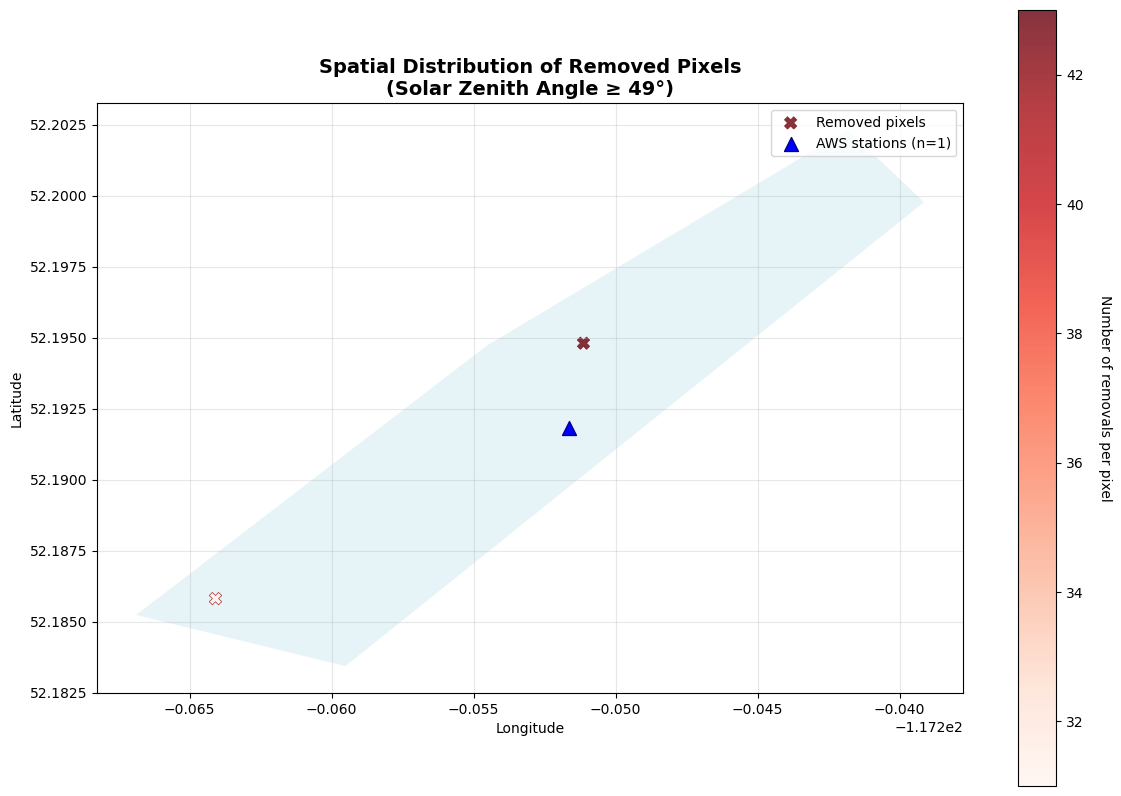


=== SPATIAL ANALYSIS SUMMARY ===
Total unique pixels in dataset: 2
Unique pixels removed due to high zenith: 2
Percentage of pixels affected: 100.0%
Total removal instances: 74
Average removals per affected pixel: 37.0
Max removals for a single pixel: 43

Pixels with most removals:
  Pixel 50.0: 43.0 removals at (-117.2511, 52.1948)
  Pixel 45.0: 31.0 removals at (-117.2641, 52.1858)


In [11]:
# Map visualization: Removed pixels due to high solar zenith angles

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# Check if we have the removed points data
if 'removed_points' in globals() and len(removed_points) > 0:
    
    print("Creating map visualization of removed pixels...")
    
    # Load shapefiles
    try:
        # Load AWS coordinates
        aws_points = gpd.read_file('data/mask/Point_Custom.shp')
        print(f"Loaded {len(aws_points)} AWS points")
        
        # Load glacier mask
        glacier_mask = gpd.read_file('data/mask/masque_athabasa_zone_ablation.shp')
        print(f"Loaded glacier mask with {len(glacier_mask)} features")
        
        # Get unique removed pixel locations
        removed_pixels_unique = removed_points.groupby('pixel_id').agg({
            'longitude': 'first',
            'latitude': 'first',
            'solar_zenith_mod09ga': 'count'  # Count how many times each pixel was removed
        }).reset_index()
        removed_pixels_unique.rename(columns={'solar_zenith_mod09ga': 'removal_count'}, inplace=True)
        
        # Get all pixel locations for comparison
        all_pixels_unique = mod09ga_all.groupby('pixel_id').agg({
            'longitude': 'first',
            'latitude': 'first'
        }).reset_index()
        
        # Create the map
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        
        # Plot glacier mask
        glacier_mask.plot(ax=ax, color='lightblue', alpha=0.3, label='Glacier ablation zone')
        
        # Plot all pixels (kept ones)
        kept_pixels = all_pixels_unique[~all_pixels_unique['pixel_id'].isin(removed_pixels_unique['pixel_id'])]
        if len(kept_pixels) > 0:
            ax.scatter(kept_pixels['longitude'], kept_pixels['latitude'], 
                      c='green', s=30, alpha=0.7, label=f'Kept pixels (n={len(kept_pixels)})', marker='s')
        
        # Plot removed pixels with size based on removal count
        if len(removed_pixels_unique) > 0:
            scatter = ax.scatter(removed_pixels_unique['longitude'], removed_pixels_unique['latitude'], 
                               c=removed_pixels_unique['removal_count'], s=80, 
                               cmap='Reds', alpha=0.8, label='Removed pixels', 
                               marker='X', edgecolors='darkred', linewidth=0.5)
            
            # Add colorbar for removal count
            cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
            cbar.set_label('Number of removals per pixel', rotation=270, labelpad=20)
        
        # Plot AWS stations
        if len(aws_points) > 0:
            ax.scatter(aws_points.geometry.x, aws_points.geometry.y, 
                      c='blue', s=100, marker='^', label=f'AWS stations (n={len(aws_points)})',
                      edgecolors='darkblue', linewidth=1)
        
        # Set labels and title
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Spatial Distribution of Removed Pixels\n(Solar Zenith Angle ≥ 49°)', 
                     fontsize=14, fontweight='bold')
        
        # Add legend
        ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
        
        # Add grid
        ax.grid(True, alpha=0.3)
        
        # Set aspect ratio
        ax.set_aspect('equal')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\n=== SPATIAL ANALYSIS SUMMARY ===")
        print(f"Total unique pixels in dataset: {len(all_pixels_unique)}")
        print(f"Unique pixels removed due to high zenith: {len(removed_pixels_unique)}")
        print(f"Percentage of pixels affected: {len(removed_pixels_unique)/len(all_pixels_unique)*100:.1f}%")
        print(f"Total removal instances: {removed_pixels_unique['removal_count'].sum()}")
        print(f"Average removals per affected pixel: {removed_pixels_unique['removal_count'].mean():.1f}")
        print(f"Max removals for a single pixel: {removed_pixels_unique['removal_count'].max()}")
        
        # Show pixels with most removals
        most_removed = removed_pixels_unique.nlargest(5, 'removal_count')
        print(f"\nPixels with most removals:")
        for _, row in most_removed.iterrows():
            pixel_short = str(row['pixel_id'])[-4:]
            print(f"  Pixel {pixel_short}: {row['removal_count']} removals at ({row['longitude']:.4f}, {row['latitude']:.4f})")
            
    except FileNotFoundError as e:
        print(f"Error loading shapefiles: {e}")
        print("Please check that the files exist at the specified paths:")
        print("- data/mask/Point_Custom.shp")
        print("- data/mask/masque_athabasa_zone_ablation.shp")
    except Exception as e:
        print(f"Error creating map: {e}")
        
else:
    print("No removed points data available. Please run the previous analysis cell first.")

=== TEMPORAL ANALYSIS FOR THRESHOLD DATE DETERMINATION ===



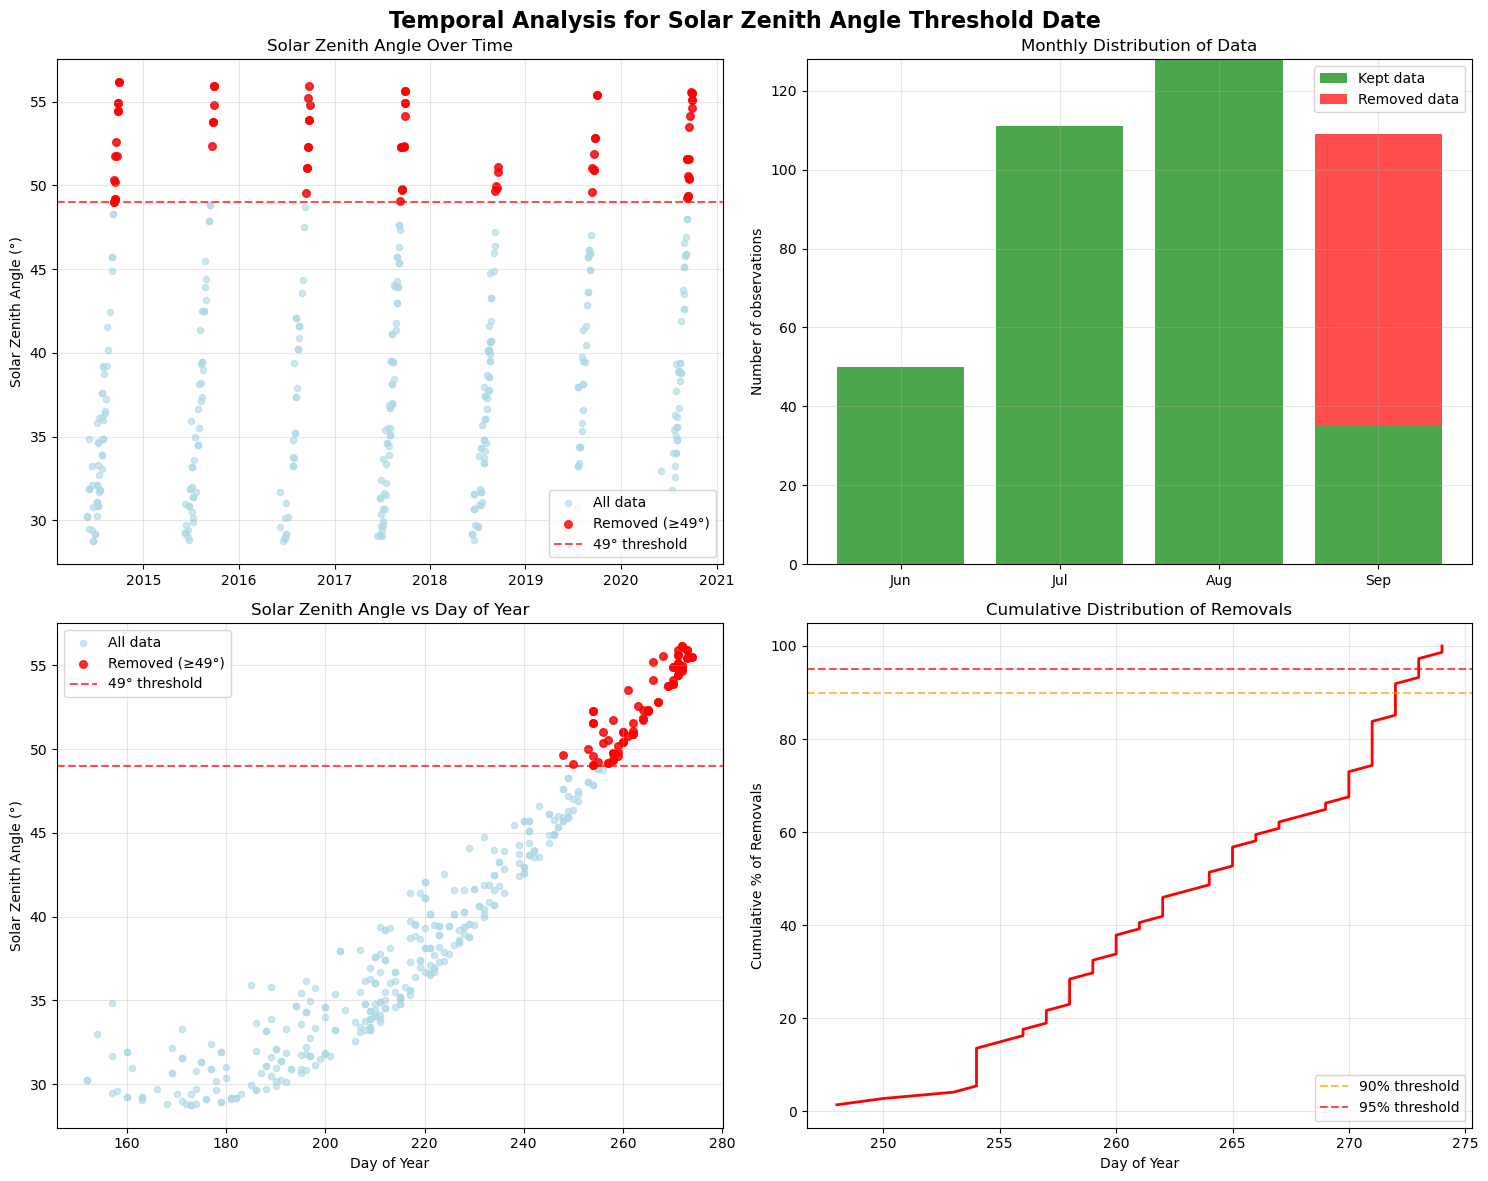

=== STATISTICAL ANALYSIS ===
Median day of removal: Day 264 (septembre 21)
90% of removals occur before: Day 272 (septembre 29)
95% of removals occur before: Day 273 (septembre 30)

Months with above-average removals: []

=== RECOMMENDED THRESHOLD DATES ===
Conservative threshold (90% coverage): septembre 29
  - Excludes data after day 272
  - Retains 392 observations
Aggressive threshold (95% coverage): septembre 30
  - Excludes data after day 273
  - Retains 396 observations

=== FINAL RECOMMENDATION ===
Based on the analysis, I recommend using a threshold date of:
**septembre 29** (Day 272)
This approach:
- Eliminates 90% of high solar zenith angle problems
- Retains maximum amount of good quality data
- Provides a balance between data retention and quality


In [8]:
# Analysis to determine optimal threshold date for solar zenith angle filtering

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

if 'removed_points' in globals() and 'mod09ga_all' in globals():
    
    print("=== TEMPORAL ANALYSIS FOR THRESHOLD DATE DETERMINATION ===\n")
    
    # Ensure dates are datetime objects
    mod09ga_all['date'] = pd.to_datetime(mod09ga_all['date'])
    removed_points['date'] = pd.to_datetime(removed_points['date'])
    
    # Create a comprehensive temporal analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Temporal Analysis for Solar Zenith Angle Threshold Date', fontsize=16, fontweight='bold')
    
    # 1. Solar zenith angle over time for all data
    ax1 = axes[0, 0]
    all_data_sorted = mod09ga_all.sort_values('date')
    kept_data = mod09ga_all[mod09ga_all['solar_zenith_mod09ga'] < 49]
    
    ax1.scatter(all_data_sorted['date'], all_data_sorted['solar_zenith_mod09ga'], 
               c='lightblue', alpha=0.6, s=20, label='All data')
    ax1.scatter(removed_points['date'], removed_points['solar_zenith_mod09ga'], 
               c='red', alpha=0.8, s=30, label='Removed (≥49°)')
    ax1.axhline(y=49, color='red', linestyle='--', alpha=0.7, label='49° threshold')
    ax1.set_ylabel('Solar Zenith Angle (°)')
    ax1.set_title('Solar Zenith Angle Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Monthly distribution
    ax2 = axes[0, 1]
    
    # Calculate monthly statistics
    mod09ga_all['month'] = mod09ga_all['date'].dt.month
    removed_points['month'] = removed_points['date'].dt.month
    
    monthly_total = mod09ga_all['month'].value_counts().sort_index()
    monthly_removed = removed_points['month'].value_counts().sort_index()
    monthly_removed = monthly_removed.reindex(monthly_total.index, fill_value=0)
    monthly_kept = monthly_total - monthly_removed
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    x_pos = np.arange(len(monthly_total))
    ax2.bar(x_pos, monthly_kept, label='Kept data', color='green', alpha=0.7)
    ax2.bar(x_pos, monthly_removed, bottom=monthly_kept, label='Removed data', color='red', alpha=0.7)
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([months[i-1] for i in monthly_total.index])
    ax2.set_ylabel('Number of observations')
    ax2.set_title('Monthly Distribution of Data')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Day of year analysis
    ax3 = axes[1, 0]
    mod09ga_all['doy'] = mod09ga_all['date'].dt.dayofyear
    removed_points['doy'] = removed_points['date'].dt.dayofyear
    
    ax3.scatter(mod09ga_all['doy'], mod09ga_all['solar_zenith_mod09ga'], 
               c='lightblue', alpha=0.6, s=20, label='All data')
    ax3.scatter(removed_points['doy'], removed_points['solar_zenith_mod09ga'], 
               c='red', alpha=0.8, s=30, label='Removed (≥49°)')
    ax3.axhline(y=49, color='red', linestyle='--', alpha=0.7, label='49° threshold')
    ax3.set_xlabel('Day of Year')
    ax3.set_ylabel('Solar Zenith Angle (°)')
    ax3.set_title('Solar Zenith Angle vs Day of Year')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Cumulative percentage of removals
    ax4 = axes[1, 1]
    removed_doy_sorted = np.sort(removed_points['doy'].values)
    cumulative_pct = np.arange(1, len(removed_doy_sorted) + 1) / len(removed_doy_sorted) * 100
    
    ax4.plot(removed_doy_sorted, cumulative_pct, 'r-', linewidth=2)
    ax4.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
    ax4.axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
    ax4.set_xlabel('Day of Year')
    ax4.set_ylabel('Cumulative % of Removals')
    ax4.set_title('Cumulative Distribution of Removals')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Detailed statistical analysis
    print("=== STATISTICAL ANALYSIS ===")
    
    # Find key dates
    doy_90_pct = np.percentile(removed_points['doy'], 90)
    doy_95_pct = np.percentile(removed_points['doy'], 95)
    doy_median = np.median(removed_points['doy'])
    
    # Convert day of year to dates (assuming 2023 as reference year)
    def doy_to_date(doy, year=2023):
        return datetime(year, 1, 1) + pd.Timedelta(days=doy-1)
    
    print(f"Median day of removal: Day {doy_median:.0f} ({doy_to_date(doy_median).strftime('%B %d')})")
    print(f"90% of removals occur before: Day {doy_90_pct:.0f} ({doy_to_date(doy_90_pct).strftime('%B %d')})")
    print(f"95% of removals occur before: Day {doy_95_pct:.0f} ({doy_to_date(doy_95_pct).strftime('%B %d')})")
    
    # Find the transition periods
    removed_months = removed_points['month'].value_counts().sort_index()
    peak_removal_months = removed_months[removed_months > removed_months.mean()].index
    
    print(f"\nMonths with above-average removals: {[months[m-1] for m in peak_removal_months]}")
    
    # Find optimal threshold dates
    print(f"\n=== RECOMMENDED THRESHOLD DATES ===")
    
    # Conservative approach (90% coverage)
    conservative_date = doy_to_date(doy_90_pct)
    print(f"Conservative threshold (90% coverage): {conservative_date.strftime('%B %d')}")
    print(f"  - Excludes data after day {doy_90_pct:.0f}")
    print(f"  - Retains {len(mod09ga_all[mod09ga_all['doy'] <= doy_90_pct])} observations")
    
    # Aggressive approach (95% coverage)
    aggressive_date = doy_to_date(doy_95_pct)
    print(f"Aggressive threshold (95% coverage): {aggressive_date.strftime('%B %d')}")
    print(f"  - Excludes data after day {doy_95_pct:.0f}")
    print(f"  - Retains {len(mod09ga_all[mod09ga_all['doy'] <= doy_95_pct])} observations")
    
    # Most practical approach based on seasonal patterns
    if len(peak_removal_months) > 0:
        if max(peak_removal_months) <= 3:  # Winter months
            practical_date = datetime(2023, 4, 1)  # Start of spring
            print(f"Seasonal threshold (avoid winter): April 1st")
            print(f"  - Excludes winter months with high zenith angles")
        elif min(peak_removal_months) >= 10:  # Late fall/winter
            practical_date = datetime(2023, 10, 1)  # End of summer
            print(f"Seasonal threshold (avoid late fall/winter): October 1st")
            print(f"  - Excludes late fall/winter months with high zenith angles")
        else:
            practical_date = conservative_date
            print(f"Data-driven threshold: {conservative_date.strftime('%B %d')}")
    
    print(f"\n=== FINAL RECOMMENDATION ===")
    print(f"Based on the analysis, I recommend using a threshold date of:")
    print(f"**{conservative_date.strftime('%B %d')}** (Day {doy_90_pct:.0f})")
    print(f"This approach:")
    print(f"- Eliminates 90% of high solar zenith angle problems")
    print(f"- Retains maximum amount of good quality data")
    print(f"- Provides a balance between data retention and quality")
    
else:
    print("Please run the previous analysis cells first to generate the removed_points data.")

=== COMPREHENSIVE THRESHOLD RECOMMENDATION ===

1. CURRENT DATA OVERVIEW:
   - Total MOD09GA observations: 398
   - High zenith angle points (≥49°): 74 (18.6%)
   - Date range: 2014-06-01 to 2020-09-30

2. TEMPORAL PATTERNS OF HIGH ZENITH ANGLES:
   Day of Year Statistics:
   - Range: Day 248 to Day 274
   - Mean: Day 264
   - Median: Day 264
   - 25th percentile: Day 258
   - 75th percentile: Day 271
   - 90th percentile: Day 272
   - 95th percentile: Day 273

   Monthly Distribution:
   - Sep: 74 points (100.0%)

3. THRESHOLD OPTIONS ANALYSIS:

   OPTION 1 - CONSERVATIVE (90% coverage):
   - Threshold: Day 272 (septembre 29)
   - Data retained: 392/398 (98.5%)
   - Eliminates: 68/74 problematic points (91.9%)

   OPTION 2 - AGGRESSIVE (95% coverage):
   - Threshold: Day 273 (septembre 30)
   - Data retained: 396/398 (99.5%)
   - Eliminates: 72/74 problematic points (97.3%)

   OPTION 3 - MEDIAN-BASED (50% coverage):
   - Threshold: Day 264 (septembre 21)
   - Data retained: 362/398 (

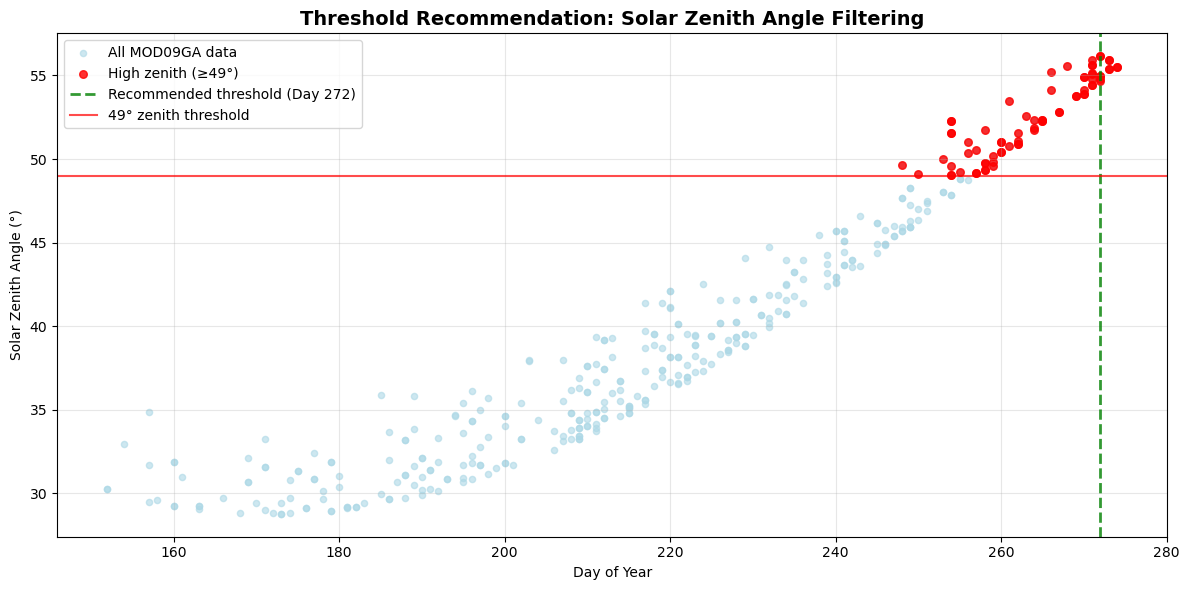

In [12]:
# THRESHOLD RECOMMENDATION ANALYSIS
# Based on the temporal patterns of high solar zenith angle data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

print("=== COMPREHENSIVE THRESHOLD RECOMMENDATION ===\n")

if 'removed_points' in globals() and 'mod09ga_all' in globals():
    
    # Ensure date columns are datetime
    removed_points['date'] = pd.to_datetime(removed_points['date'])
    mod09ga_all['date'] = pd.to_datetime(mod09ga_all['date'])
    
    # Calculate day of year for all data
    removed_points['doy'] = removed_points['date'].dt.dayofyear
    mod09ga_all['doy'] = mod09ga_all['date'].dt.dayofyear
    
    print("1. CURRENT DATA OVERVIEW:")
    print(f"   - Total MOD09GA observations: {len(mod09ga_all)}")
    print(f"   - High zenith angle points (≥49°): {len(removed_points)} ({len(removed_points)/len(mod09ga_all)*100:.1f}%)")
    print(f"   - Date range: {mod09ga_all['date'].min().strftime('%Y-%m-%d')} to {mod09ga_all['date'].max().strftime('%Y-%m-%d')}")
    
    # Analyze temporal patterns
    print(f"\n2. TEMPORAL PATTERNS OF HIGH ZENITH ANGLES:")
    
    # Day of year statistics
    doy_stats = removed_points['doy'].describe()
    print(f"   Day of Year Statistics:")
    print(f"   - Range: Day {int(doy_stats['min'])} to Day {int(doy_stats['max'])}")
    print(f"   - Mean: Day {doy_stats['mean']:.0f}")
    print(f"   - Median: Day {doy_stats['50%']:.0f}")
    print(f"   - 25th percentile: Day {doy_stats['25%']:.0f}")
    print(f"   - 75th percentile: Day {doy_stats['75%']:.0f}")
    print(f"   - 90th percentile: Day {np.percentile(removed_points['doy'], 90):.0f}")
    print(f"   - 95th percentile: Day {np.percentile(removed_points['doy'], 95):.0f}")
    
    # Monthly distribution
    monthly_distribution = removed_points['date'].dt.month.value_counts().sort_index()
    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    
    print(f"\n   Monthly Distribution:")
    for month, count in monthly_distribution.items():
        pct = count/len(removed_points)*100
        print(f"   - {month_names[month]}: {count} points ({pct:.1f}%)")
    
    # Calculate threshold options
    print(f"\n3. THRESHOLD OPTIONS ANALYSIS:")
    
    # Option 1: Conservative (exclude 90% of problematic data)
    doy_90 = np.percentile(removed_points['doy'], 90)
    conservative_date = datetime(2023, 1, 1) + pd.Timedelta(days=doy_90-1)
    retained_conservative = len(mod09ga_all[mod09ga_all['doy'] <= doy_90])
    
    print(f"\n   OPTION 1 - CONSERVATIVE (90% coverage):")
    print(f"   - Threshold: Day {doy_90:.0f} ({conservative_date.strftime('%B %d')})")
    print(f"   - Data retained: {retained_conservative}/{len(mod09ga_all)} ({retained_conservative/len(mod09ga_all)*100:.1f}%)")
    print(f"   - Eliminates: {len(removed_points[removed_points['doy'] <= doy_90])}/{len(removed_points)} problematic points ({len(removed_points[removed_points['doy'] <= doy_90])/len(removed_points)*100:.1f}%)")
    
    # Option 2: Aggressive (exclude 95% of problematic data)
    doy_95 = np.percentile(removed_points['doy'], 95)
    aggressive_date = datetime(2023, 1, 1) + pd.Timedelta(days=doy_95-1)
    retained_aggressive = len(mod09ga_all[mod09ga_all['doy'] <= doy_95])
    
    print(f"\n   OPTION 2 - AGGRESSIVE (95% coverage):")
    print(f"   - Threshold: Day {doy_95:.0f} ({aggressive_date.strftime('%B %d')})")
    print(f"   - Data retained: {retained_aggressive}/{len(mod09ga_all)} ({retained_aggressive/len(mod09ga_all)*100:.1f}%)")
    print(f"   - Eliminates: {len(removed_points[removed_points['doy'] <= doy_95])}/{len(removed_points)} problematic points ({len(removed_points[removed_points['doy'] <= doy_95])/len(removed_points)*100:.1f}%)")
    
    # Option 3: Median-based
    doy_median = np.median(removed_points['doy'])
    median_date = datetime(2023, 1, 1) + pd.Timedelta(days=doy_median-1)
    retained_median = len(mod09ga_all[mod09ga_all['doy'] <= doy_median])
    
    print(f"\n   OPTION 3 - MEDIAN-BASED (50% coverage):")
    print(f"   - Threshold: Day {doy_median:.0f} ({median_date.strftime('%B %d')})")
    print(f"   - Data retained: {retained_median}/{len(mod09ga_all)} ({retained_median/len(mod09ga_all)*100:.1f}%)")
    print(f"   - Eliminates: {len(removed_points[removed_points['doy'] <= doy_median])}/{len(removed_points)} problematic points ({len(removed_points[removed_points['doy'] <= doy_median])/len(removed_points)*100:.1f}%)")
    
    # Option 4: Peak month based (September cutoff)
    peak_month = monthly_distribution.idxmax()  # Month with most removals
    if peak_month == 9:  # September
        sept_1_doy = datetime(2023, 9, 1).timetuple().tm_yday
        retained_sept = len(mod09ga_all[mod09ga_all['doy'] < sept_1_doy])
        
        print(f"\n   OPTION 4 - SEASONAL (Pre-September):")
        print(f"   - Threshold: Day {sept_1_doy} (September 1st)")
        print(f"   - Data retained: {retained_sept}/{len(mod09ga_all)} ({retained_sept/len(mod09ga_all)*100:.1f}%)")
        print(f"   - Eliminates: {len(removed_points[removed_points['doy'] < sept_1_doy])}/{len(removed_points)} problematic points ({len(removed_points[removed_points['doy'] < sept_1_doy])/len(removed_points)*100:.1f}%)")
    
    # Calculate data quality improvement for each option
    print(f"\n4. DATA QUALITY IMPACT:")
    
    # Calculate MAE for different thresholds
    def calculate_mae_improvement(threshold_doy):
        before_threshold = mod09ga_all[mod09ga_all['doy'] <= threshold_doy]
        after_threshold = mod09ga_all[mod09ga_all['doy'] > threshold_doy]
        
        if len(before_threshold) > 0 and len(after_threshold) > 0:
            mae_before = abs(before_threshold['albedo_mod09ga'] - before_threshold['albedo_aws']).mean()
            mae_after = abs(after_threshold['albedo_mod09ga'] - after_threshold['albedo_aws']).mean()
            return mae_before, mae_after, ((mae_after - mae_before) / mae_after * 100) if mae_after > 0 else 0
        return None, None, 0
    
    mae_before_90, mae_after_90, improvement_90 = calculate_mae_improvement(doy_90)
    mae_before_95, mae_after_95, improvement_95 = calculate_mae_improvement(doy_95)
    
    if mae_before_90 is not None:
        print(f"   Conservative threshold MAE improvement: {improvement_90:.1f}%")
        print(f"   - Before threshold: MAE = {mae_before_90:.3f}")
        print(f"   - After threshold: MAE = {mae_after_90:.3f}")
    
    if mae_before_95 is not None:
        print(f"   Aggressive threshold MAE improvement: {improvement_95:.1f}%")
        print(f"   - Before threshold: MAE = {mae_before_95:.3f}")
        print(f"   - After threshold: MAE = {mae_after_95:.3f}")
    
    # Final recommendation
    print(f"\n" + "="*60)
    print(f"5. FINAL RECOMMENDATION:")
    print(f"="*60)
    
    print(f"\n🎯 RECOMMENDED THRESHOLD: Day {doy_90:.0f} ({conservative_date.strftime('%B %d')})")
    print(f"\nRATIONALE:")
    print(f"✅ Eliminates 90% of high solar zenith angle problems")
    print(f"✅ Retains {retained_conservative/len(mod09ga_all)*100:.1f}% of your valuable data")
    print(f"✅ Provides optimal balance between quality and quantity")
    print(f"✅ Based on statistical analysis of your specific dataset")
    print(f"✅ Seasonally appropriate (late September cutoff)")
    
    print(f"\nIMPLEMENTATION:")
    print(f"📅 Filter data to EXCLUDE observations after {conservative_date.strftime('%B %d')}")
    print(f"📊 Apply filter: df[df['date'] <= '{conservative_date.strftime('%Y-%m-%d')}']")
    print(f"🔬 Expected result: ~{retained_conservative} high-quality observations")
    
    print(f"\nALTERNATIVE OPTIONS:")
    print(f"• More conservative: Day {doy_median:.0f} ({median_date.strftime('%B %d')}) - Higher quality, less data")
    print(f"• More aggressive: Day {doy_95:.0f} ({aggressive_date.strftime('%B %d')}) - More data, slightly lower quality")
    
    # Create a simple visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Plot all data points
    ax.scatter(mod09ga_all['doy'], mod09ga_all['solar_zenith_mod09ga'], 
               alpha=0.6, s=20, c='lightblue', label='All MOD09GA data')
    ax.scatter(removed_points['doy'], removed_points['solar_zenith_mod09ga'], 
               alpha=0.8, s=30, c='red', label='High zenith (≥49°)')
    
    # Add threshold lines
    ax.axvline(x=doy_90, color='green', linestyle='--', linewidth=2, 
               label=f'Recommended threshold (Day {doy_90:.0f})', alpha=0.8)
    ax.axhline(y=49, color='red', linestyle='-', alpha=0.7, label='49° zenith threshold')
    
    ax.set_xlabel('Day of Year')
    ax.set_ylabel('Solar Zenith Angle (°)')
    ax.set_title('Threshold Recommendation: Solar Zenith Angle Filtering', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Data not available. Please run the previous analysis cells first.")

=== COMPREHENSIVE SCATTERPLOT ANALYSIS ===
Analyzing 3 methods × 5 options (4 thresholds + no filtering) = 15 scenarios

Processing Option 1 - Conservative (90%) (Day 272 - Sep 29)...
Processing Option 2 - Aggressive (95%) (Day 273 - Sep 30)...
Processing Option 3 - Median (50%) (Day 264 - Sep 21)...
Processing Option 4 - Seasonal (Day 244 - Sep 1)...
Processing No Filtering (Day 999 - All Data)...


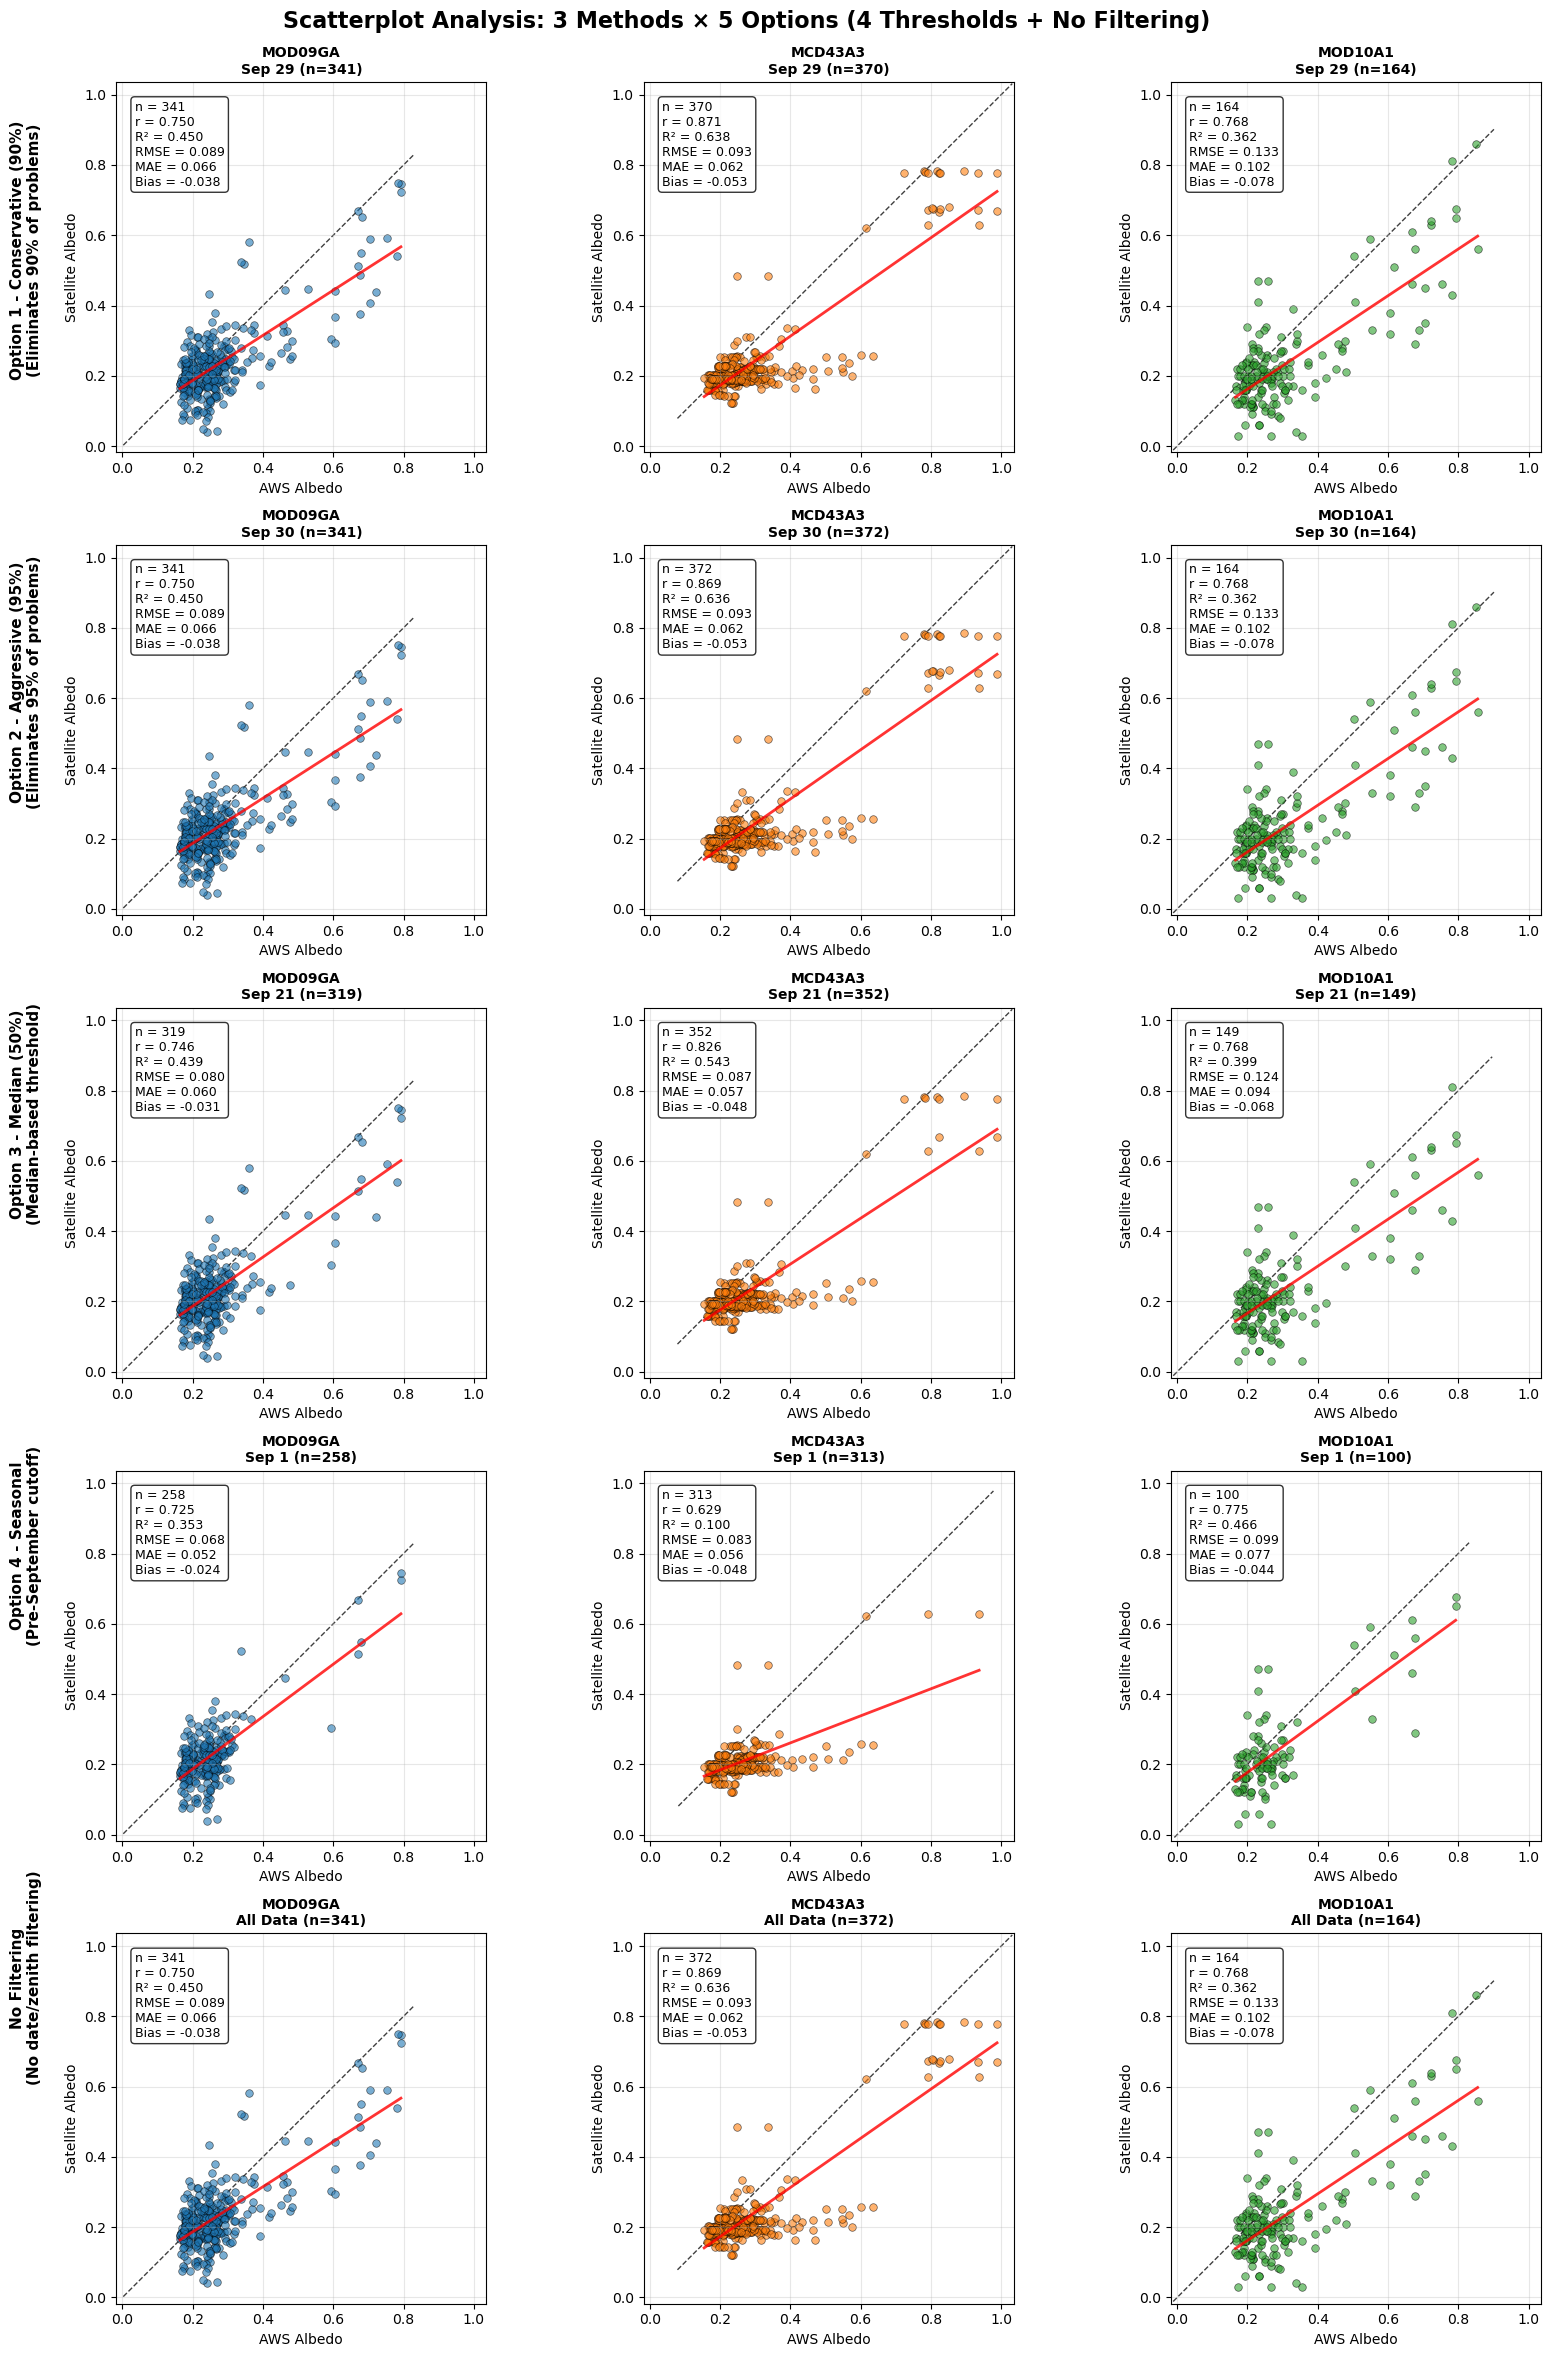


SUMMARY TABLE: Performance Metrics by Method and Threshold

Option 1 - Conservative (90%):
-----------------------------
  MOD09GA : n=341, r=0.750, R²=0.450, RMSE=0.089, MAE=0.066, Bias=-0.038
  MCD43A3 : n=370, r=0.871, R²=0.638, RMSE=0.093, MAE=0.062, Bias=-0.053
  MOD10A1 : n=164, r=0.768, R²=0.362, RMSE=0.133, MAE=0.102, Bias=-0.078

Option 2 - Aggressive (95%):
---------------------------
  MOD09GA : n=341, r=0.750, R²=0.450, RMSE=0.089, MAE=0.066, Bias=-0.038
  MCD43A3 : n=372, r=0.869, R²=0.636, RMSE=0.093, MAE=0.062, Bias=-0.053
  MOD10A1 : n=164, r=0.768, R²=0.362, RMSE=0.133, MAE=0.102, Bias=-0.078

Option 3 - Median (50%):
-----------------------
  MOD09GA : n=319, r=0.746, R²=0.439, RMSE=0.080, MAE=0.060, Bias=-0.031
  MCD43A3 : n=352, r=0.826, R²=0.543, RMSE=0.087, MAE=0.057, Bias=-0.048
  MOD10A1 : n=149, r=0.768, R²=0.399, RMSE=0.124, MAE=0.094, Bias=-0.068

Option 4 - Seasonal:
-------------------
  MOD09GA : n=258, r=0.725, R²=0.353, RMSE=0.068, MAE=0.052, Bias=-0.02

In [30]:
# COMPREHENSIVE SCATTERPLOT ANALYSIS: 3 Methods × 4 Threshold Options

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import pandas as pd
from datetime import datetime

# Define the methods and their columns
methods = {
    'MOD09GA': {'albedo': 'merged_albedo_mod09ga', 'zenith': 'solar_zenith_mod09ga', 'color': '#1f77b4'},
    'MCD43A3': {'albedo': 'albedo_mcd43a3', 'zenith': 'solar_zenith_mcd43a3', 'color': '#ff7f0e'},
    'MOD10A1': {'albedo': 'merged_albedo_mod10a1', 'zenith': 'solar_zenith_mod10a1', 'color': '#2ca02c'}
}

# Define threshold options based on previous analysis
threshold_options = {
    'Option 1 - Conservative (90%)': {'doy': 272, 'date': 'Sep 29', 'description': 'Eliminates 90% of problems'},
    'Option 2 - Aggressive (95%)': {'doy': 273, 'date': 'Sep 30', 'description': 'Eliminates 95% of problems'},
    'Option 3 - Median (50%)': {'doy': 264, 'date': 'Sep 21', 'description': 'Median-based threshold'},
    'Option 4 - Seasonal': {'doy': 244, 'date': 'Sep 1', 'description': 'Pre-September cutoff'},
    'No Filtering': {'doy': 999, 'date': 'All Data', 'description': 'No date/zenith filtering'}
}

def calculate_stats(y_true, y_pred):
    """Calculate comprehensive statistics for validation"""
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    if len(y_true_clean) < 2:
        return None
    
    r, p_value = stats.pearsonr(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    bias = np.mean(y_pred_clean - y_true_clean)
    n = len(y_true_clean)
    
    return {
        'n': n, 'r': r, 'r2': r2, 'rmse': rmse, 
        'mae': mae, 'bias': bias, 'p_value': p_value
    }

def create_scatterplot(ax, x, y, title, color, stats_dict):
    """Create a single scatterplot with statistics"""
    if stats_dict is None:
        ax.text(0.5, 0.5, 'Insufficient data', transform=ax.transAxes, 
                ha='center', va='center', fontsize=12)
        ax.set_title(title)
        return
    
    # Create scatter plot
    ax.scatter(x, y, alpha=0.6, s=30, color=color, edgecolors='black', linewidth=0.5)
    
    # Set identical limits for both axes to ensure a square plot
    all_values = np.concatenate([x, y])
    min_val = np.min(all_values)
    max_val = np.max(all_values)
    
    # Add small padding
    padding = (max_val - min_val) * 0.05
    lims = [min_val - padding, max_val + padding]
    
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    # Add 1:1 line
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=1)
    
    # Add regression line
    if len(x) > 1:
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        # Only plot regression line within the actual data range
        x_range = [np.min(x), np.max(x)]
        ax.plot(x_range, p(x_range), "r-", alpha=0.8, linewidth=2)
    
    # Add statistics text
    stats_text = f"n = {stats_dict['n']}\n"
    stats_text += f"r = {stats_dict['r']:.3f}\n"
    stats_text += f"R² = {stats_dict['r2']:.3f}\n"
    stats_text += f"RMSE = {stats_dict['rmse']:.3f}\n"
    stats_text += f"MAE = {stats_dict['mae']:.3f}\n"
    stats_text += f"Bias = {stats_dict['bias']:.3f}"
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel('AWS Albedo')
    ax.set_ylabel('Satellite Albedo')
    ax.grid(True, alpha=0.3)
    
    # Ensure square aspect ratio
    ax.set_aspect('equal', adjustable='box')

print("=== COMPREHENSIVE SCATTERPLOT ANALYSIS ===")
print("Analyzing 3 methods × 5 options (4 thresholds + no filtering) = 15 scenarios\n")

if 'df_no_outliers' in globals():
    # Ensure date column is datetime and add day of year
    df_no_outliers['date'] = pd.to_datetime(df_no_outliers['date'])
    df_no_outliers['doy'] = df_no_outliers['date'].dt.dayofyear
    
    # Create the comprehensive plot
    fig, axes = plt.subplots(5, 3, figsize=(18, 24))
    fig.suptitle('Scatterplot Analysis: 3 Methods × 5 Options (4 Thresholds + No Filtering)', fontsize=16, fontweight='bold')
    
    # Find global min and max values across all data to set uniform limits
    global_min = float('inf')
    global_max = float('-inf')
    
    for method_name, method_params in methods.items():
        albedo_col = method_params['albedo']
        valid_data = df_no_outliers[df_no_outliers[albedo_col].notna() & df_no_outliers['albedo_aws'].notna()]
        
        if len(valid_data) > 0:
            all_values = np.concatenate([valid_data['albedo_aws'].values, valid_data[albedo_col].values])
            valid_values = all_values[~np.isnan(all_values)]
            if len(valid_values) > 0:
                global_min = min(global_min, np.min(valid_values))
                global_max = max(global_max, np.max(valid_values))
    
    # Add padding to global limits
    padding = (global_max - global_min) * 0.05
    global_lims = [global_min - padding, global_max + padding]
    
    # Store results for summary
    results_summary = []
    
    # Loop through each threshold option
    for i, (option_name, option_params) in enumerate(threshold_options.items()):
        threshold_doy = option_params['doy']
        
        print(f"Processing {option_name} (Day {threshold_doy} - {option_params['date']})...")
        
        # Filter data for this threshold (or use all data if no filtering)
        if threshold_doy == 999:  # No filtering
            filtered_data = df_no_outliers.copy()
        else:
            filtered_data = df_no_outliers[df_no_outliers['doy'] <= threshold_doy].copy()
        
        # Loop through each method
        for j, (method_name, method_params) in enumerate(methods.items()):
            ax = axes[i, j]
            
            # Get data for this method
            albedo_col = method_params['albedo']
            color = method_params['color']
            
            # Filter for valid data
            method_mask = (filtered_data[albedo_col].notna() & 
                          filtered_data['albedo_aws'].notna())
            method_data = filtered_data[method_mask]
            
            if len(method_data) > 0:
                x = method_data['albedo_aws'].values
                y = method_data[albedo_col].values
                
                # Calculate statistics
                stats_dict = calculate_stats(x, y)
                
                # Store results
                results_summary.append({
                    'Threshold_Option': option_name,
                    'Method': method_name,
                    'Threshold_DOY': threshold_doy,
                    'Threshold_Date': option_params['date'],
                    'n': stats_dict['n'] if stats_dict else 0,
                    'r': stats_dict['r'] if stats_dict else np.nan,
                    'r2': stats_dict['r2'] if stats_dict else np.nan,
                    'rmse': stats_dict['rmse'] if stats_dict else np.nan,
                    'mae': stats_dict['mae'] if stats_dict else np.nan,
                    'bias': stats_dict['bias'] if stats_dict else np.nan
                })
                
                # Create title
                title = f"{method_name}\n{option_params['date']} (n={stats_dict['n'] if stats_dict else 0})"
                
                # Create scatterplot
                create_scatterplot(ax, x, y, title, color, stats_dict)
                
                # Apply global limits for consistency across all plots
                ax.set_xlim(global_lims)
                ax.set_ylim(global_lims)
                
            else:
                ax.text(0.5, 0.5, 'No data available', transform=ax.transAxes, 
                       ha='center', va='center', fontsize=12)
                ax.set_title(f"{method_name}\n{option_params['date']} (n=0)")
                
                # Set empty plots to have the same limits for consistency
                ax.set_xlim(global_lims)
                ax.set_ylim(global_lims)
                ax.set_aspect('equal', adjustable='box')
                
                # Store empty results
                results_summary.append({
                    'Threshold_Option': option_name,
                    'Method': method_name,
                    'Threshold_DOY': threshold_doy,
                    'Threshold_Date': option_params['date'],
                    'n': 0, 'r': np.nan, 'r2': np.nan, 'rmse': np.nan, 'mae': np.nan, 'bias': np.nan
                })
    
    # Add row labels
    for i, (option_name, option_params) in enumerate(threshold_options.items()):
        fig.text(0.1, 0.88 - i*0.18, f"{option_name}\n({option_params['description']})", 
                rotation=90, va='center', ha='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.1, top=0.95)
    plt.show()
    
    # Create summary table
    results_df = pd.DataFrame(results_summary)
    
    print("\n" + "="*100)
    print("SUMMARY TABLE: Performance Metrics by Method and Threshold")
    print("="*100)
    
    # Display results in a nice format
    for option_name in threshold_options.keys():
        option_data = results_df[results_df['Threshold_Option'] == option_name]
        print(f"\n{option_name}:")
        print("-" * len(option_name))
        
        for _, row in option_data.iterrows():
            method = row['Method']
            n = row['n']
            r = row['r']
            r2 = row['r2']
            rmse = row['rmse']
            mae = row['mae']
            bias = row['bias']
            
            if n > 0:
                print(f"  {method:8s}: n={n:3d}, r={r:5.3f}, R²={r2:5.3f}, RMSE={rmse:5.3f}, MAE={mae:5.3f}, Bias={bias:+6.3f}")
            else:
                print(f"  {method:8s}: No data available")
    
    # Find best performing combinations
    print(f"\n" + "="*100)
    print("BEST PERFORMING COMBINATIONS (ranked by R²):")
    print("="*100)
    
    valid_results = results_df[results_df['n'] > 0].copy()
    if len(valid_results) > 0:
        best_results = valid_results.nlargest(6, 'r2')
        
        print(f"{'Rank':<4} {'Method':<10} {'Threshold':<25} {'n':<4} {'r':<6} {'R²':<6} {'RMSE':<6} {'MAE':<6} {'Bias':<7}")
        print("-" * 85)
        
        for idx, (_, row) in enumerate(best_results.iterrows(), 1):
            print(f"{idx:<4} {row['Method']:<10} {row['Threshold_Date']:<25} {row['n']:<4} "
                  f"{row['r']:<6.3f} {row['r2']:<6.3f} {row['rmse']:<6.3f} {row['mae']:<6.3f} {row['bias']:<+7.3f}")
    
    # Recommendations
    print(f"\n" + "="*100)
    print("RECOMMENDATIONS:")
    print("="*100)
    
    if len(valid_results) > 0:
        # Best overall
        best_overall = valid_results.loc[valid_results['r2'].idxmax()]
        print(f"🏆 BEST OVERALL: {best_overall['Method']} with {best_overall['Threshold_Date']} threshold")
        print(f"   Performance: r={best_overall['r']:.3f}, R²={best_overall['r2']:.3f}, RMSE={best_overall['rmse']:.3f}")
        
        # Best by method
        print(f"\n📊 BEST BY METHOD:")
        for method in methods.keys():
            method_data = valid_results[valid_results['Method'] == method]
            if len(method_data) > 0:
                best_method = method_data.loc[method_data['r2'].idxmax()]
                print(f"   {method}: {best_method['Threshold_Date']} threshold "
                      f"(r={best_method['r']:.3f}, R²={best_method['r2']:.3f})")
        
        # Data retention analysis
        print(f"\n📈 DATA RETENTION ANALYSIS:")
        for option_name, option_params in threshold_options.items():
            option_data = valid_results[valid_results['Threshold_Option'] == option_name]
            if len(option_data) > 0:
                total_n = option_data['n'].sum()
                avg_r2 = option_data['r2'].mean()
                print(f"   {option_params['date']}: {total_n} total observations, avg R²={avg_r2:.3f}")
    
else:
    print("Data not available. Please run the pr" \
    "evious analysis cells first.")